# 1차 완성 모델
* 코너 및 점선에 취약함
* 원근 변환 포인트를 잘 잡지 못함

In [10]:
import cv2
import torch
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from ultralytics import YOLO

# matplotlib 한글 폰트 설정
import matplotlib.font_manager as fm
import platform

def setup_matplotlib_font():
    # 운영체제별 기본 폰트 설정
    system = platform.system()
    if system == 'Windows':
        font_path = 'C:/Windows/Fonts/malgun.ttf'  # 윈도우의 경우 맑은 고딕
    elif system == 'Darwin':  # macOS
        font_path = '/System/Library/Fonts/AppleSDGothicNeo.ttc'
    else:  # Linux
        font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 우분투 기준 나눔고딕

    # 폰트 패스가 유효한지 확인
    try:
        font_prop = fm.FontProperties(fname=font_path)
        plt.rcParams['font.family'] = font_prop.get_name()
    except:
        print("기본 폰트를 사용합니다. 한글이 깨질 수 있습니다.")
        plt.rcParams['font.family'] = 'NanumGothic'  # 나눔고딕이 설치되어 있으면 사용

    # 그래프에서 마이너스 폰트 깨짐 방지
    plt.rcParams['axes.unicode_minus'] = False

def extract_road_mask(img):
    """도로 영역 추출 함수"""
    # HSV 변환
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # 도로 색상 범위 (회색 계열)
    lower_road = np.array([0, 0, 60])
    upper_road = np.array([180, 30, 160])
    road_mask = cv2.inRange(hsv, lower_road, upper_road)
    
    # 이미지 높이의 하단 75%만 고려 (상단 25% 제외)
    height = img.shape[0]
    road_mask[:int(height * 0.25), :] = 0
    
    # 노이즈 제거를 위한 모폴로지 연산
    kernel = np.ones((15, 15), np.uint8)
    road_mask = cv2.morphologyEx(road_mask, cv2.MORPH_CLOSE, kernel)
    road_mask = cv2.morphologyEx(road_mask, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))
    
    # 가장 큰 연결 요소만 유지
    contours, _ = cv2.findContours(road_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        max_contour = max(contours, key=cv2.contourArea)
        if cv2.contourArea(max_contour) > (height * img.shape[1] * 0.1):
            refined_mask = np.zeros_like(road_mask)
            cv2.drawContours(refined_mask, [max_contour], 0, 255, -1)
            road_mask = refined_mask
    
    return road_mask

def detect_lane_lines(img):
    """차선 감지 및 마스크 생성 함수"""
    # 그레이스케일 변환
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 가우시안 블러 및 엣지 감지
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)
    
    # ROI 설정 - 상단 25%를 제외한 영역만 고려
    height, width = edges.shape
    roi_mask = np.ones_like(edges)
    roi_mask[:int(height * 0.25), :] = 0
    masked_edges = cv2.bitwise_and(edges, edges, mask=roi_mask)
    
    # 색상 기반 차선 추출 (흰색/노란색)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # 흰색 및 노란색 범위 설정
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 30, 255])
    white_mask = cv2.inRange(hsv, lower_white, upper_white)
    
    lower_yellow = np.array([10, 60, 80])
    upper_yellow = np.array([40, 255, 255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    # 색상 마스크 통합 및 ROI 적용
    color_mask = cv2.bitwise_or(white_mask, yellow_mask)
    color_mask = cv2.bitwise_and(color_mask, color_mask, mask=roi_mask)
    
    # 최종 마스크 (엣지 + 색상)
    final_mask = cv2.bitwise_or(masked_edges, color_mask)
    
    # 호프 변환으로 직선 검출
    lines = cv2.HoughLinesP(
        final_mask, 
        rho=1, 
        theta=np.pi/180, 
        threshold=40,
        minLineLength=30,
        maxLineGap=5
    )
    
    # 차선 마스크 초기화
    lane_mask = np.zeros_like(gray)
    left_line_mask = np.zeros_like(gray)
    right_line_mask = np.zeros_like(gray)
    
    # 차선 필터링 및 분류
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            
            # 선의 길이가 너무 짧으면 무시
            if np.sqrt((x2 - x1)**2 + (y2 - y1)**2) < 30:
                continue
                
            # 기울기 계산
            if x2 - x1 == 0:  # 수직선 방지
                continue
            else:
                slope = (y2 - y1) / (x2 - x1)
            
            # 적절한 기울기 범위만 선택 (약 15도 ~ 65도 범위)
            if 0.3 < abs(slope) < 2:  
                cv2.line(lane_mask, (x1, y1), (x2, y2), 255, 3)
                
                # 왼쪽/오른쪽 차선 구분
                mid_x = width // 2
                line_mid_x = (x1 + x2) // 2
                
                if slope < 0 and line_mid_x < mid_x:  # 왼쪽 차선 (음수 기울기)
                    cv2.line(left_line_mask, (x1, y1), (x2, y2), 255, 3)
                elif slope > 0 and line_mid_x > mid_x:  # 오른쪽 차선 (양수 기울기)
                    cv2.line(right_line_mask, (x1, y1), (x2, y2), 255, 3)
    
    # 차선 마스크 확장
    kernel = np.ones((3, 3), np.uint8)
    lane_mask = cv2.dilate(lane_mask, kernel, iterations=1)
    
    return lane_mask, left_line_mask, right_line_mask, edges, masked_edges

def extract_road_between_lanes(img, road_mask, left_lane_mask, right_lane_mask):
    """차선 내부의 도로 영역 추출 함수"""
    height, width = road_mask.shape
    
    # 왼쪽과 오른쪽 차선 윤곽선 찾기
    left_contours, _ = cv2.findContours(left_lane_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    right_contours, _ = cv2.findContours(right_lane_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 차선 마스크가 충분하지 않으면 기본 도로 마스크 반환
    if not left_contours or not right_contours:
        return road_mask, None
    
    # 가장 큰 왼쪽/오른쪽 차선 윤곽선 선택
    left_contour = max(left_contours, key=cv2.contourArea) if left_contours else None
    right_contour = max(right_contours, key=cv2.contourArea) if right_contours else None
    
    if left_contour is None or right_contour is None:
        return road_mask, None
    
    # 왼쪽/오른쪽 차선의 외곽점 찾기
    left_points = left_contour.reshape(-1, 2)
    right_points = right_contour.reshape(-1, 2)
    
    # 각 차선에서 가장 아래/위 지점 찾기
    left_bottom = left_points[np.argmax(left_points[:, 1])]
    right_bottom = right_points[np.argmax(right_points[:, 1])]
    left_top = left_points[np.argmin(left_points[:, 1])]
    right_top = right_points[np.argmin(right_points[:, 1])]
    
    # 차선이 충분히 감지되지 않은 경우 대체 포인트 설정
    if np.linalg.norm(left_top - left_bottom) < 50:
        left_top[1] = max(0, height - height//3)
    
    if np.linalg.norm(right_top - right_bottom) < 50:
        right_top[1] = max(0, height - height//3)
        
    # 이미지 하단 좌표 추가
    bottom_left = [0, height-1]
    bottom_right = [width-1, height-1]
    
    # 도로 폴리곤 생성 (차선 내부 + 차선 아래 영역)
    road_polygon = np.array([
        bottom_left, left_bottom, left_top, right_top, right_bottom, bottom_right
    ], dtype=np.int32)
    
    # 도로 영역 마스크 생성
    lane_road_mask = np.zeros_like(road_mask)
    cv2.fillPoly(lane_road_mask, [road_polygon], 255)
    
    # 원래 도로 마스크와 교차
    final_road_mask = cv2.bitwise_and(road_mask, lane_road_mask)
    
    return final_road_mask, road_polygon

def get_default_perspective_points(road_polygon, height, width):
    """road_polygon이 있을 경우 사용하고, 없으면 기본값 설정"""
    if road_polygon is not None and len(road_polygon) >= 6:
        # road_polygon에서 필요한 포인트 추출
        left_bottom = road_polygon[1]  # 왼쪽 차선 하단
        right_bottom = road_polygon[4] # 오른쪽 차선 하단
        left_top = road_polygon[2]     # 왼쪽 차선 상단
        right_top = road_polygon[3]    # 오른쪽 차선 상단
        
        # 사용할 코너 포인트
        return np.float32([left_bottom, right_bottom, left_top, right_top])
    else:
        # 기본값 설정
        bottom_left = np.array([0, height-1])
        bottom_right = np.array([width-1, height-1])
        top_left = np.array([width//4, height//3])
        top_right = np.array([width*3//4, height//3])
        
        return np.float32([bottom_left, bottom_right, top_left, top_right])

def perspective_transform(img, mask, road_polygon=None):
    """
    원근 변환 함수 - 도로 마스크(road_lane_mask)의 모서리 포인트를 사용
    y값이 작은 지점을 우선적으로 선택하여 상단 포인트 설정
    """
    height, width = mask.shape
    
    # 도로 마스크에서 윤곽선 찾기
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours and len(contours) > 0:
        # 가장 큰 윤곽선 선택
        main_contour = max(contours, key=cv2.contourArea)
        all_points = main_contour.reshape(-1, 2)
        
        if len(all_points) > 0:
            # 왼쪽 하단: x값 최소, y값 최대
            left_bottom_idx = np.lexsort((all_points[:, 0], -all_points[:, 1]))[0]
            left_bottom = all_points[left_bottom_idx]
            
            # 오른쪽 하단: x값 최대, y값 최대
            right_bottom_idx = np.lexsort((-all_points[:, 0], -all_points[:, 1]))[0]
            right_bottom = all_points[right_bottom_idx]
            
            # 상단 부분의 포인트 추출 (y값이 하위 10% 이내인 점들)
            y_threshold = np.percentile(all_points[:, 1], 10)
            top_points = all_points[all_points[:, 1] <= y_threshold]
            
            if len(top_points) > 0:
                # 왼쪽 상단: 상단 부분에서 x값이 가장 작은 점
                left_top_idx = np.argmin(top_points[:, 0])
                left_top = top_points[left_top_idx]
                
                # 오른쪽 상단: 상단 부분에서 x값이 가장 큰 점
                right_top_idx = np.argmax(top_points[:, 0])
                right_top = top_points[right_top_idx]
            else:
                # 상단 부분 포인트가 부족한 경우, y값을 우선 정렬하여 가장 작은 y값을 가진 포인트 중에서 선택
                sorted_by_y = all_points[np.argsort(all_points[:, 1])]
                top_n_points = sorted_by_y[:max(5, len(sorted_by_y) // 10)]  # 상위 10% 또는 최소 5개
                
                # 이 포인트들 중에서 왼쪽/오른쪽 구분
                left_top_idx = np.argmin(top_n_points[:, 0])
                left_top = top_n_points[left_top_idx]
                
                right_top_idx = np.argmax(top_n_points[:, 0])
                right_top = top_n_points[right_top_idx]
            
            src_points = np.float32([left_bottom, right_bottom, left_top, right_top])
        else:
            # 포인트가 없는 경우 기본값 사용
            src_points = get_default_perspective_points(road_polygon, height, width)
    else:
        # 윤곽선이 없는 경우 기본값 사용
        src_points = get_default_perspective_points(road_polygon, height, width)
    
    # 타겟 포인트 설정 (변환 후 이미지에서의 위치)
    dst_points = np.float32([
        [0, height-1],               # 왼쪽 하단
        [width-1, height-1],         # 오른쪽 하단
        [0, 0],                      # 왼쪽 상단
        [width-1, 0]                 # 오른쪽 상단
    ])
    
    # 원근 변환 행렬 계산 및 적용
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    warped_img = cv2.warpPerspective(img, M, (width, height))
    warped_mask = cv2.warpPerspective(mask, M, (width, height))
    
    return warped_img, warped_mask, M, src_points

def apply_yolo_on_masked_area(model, img, mask):
    """마스크된 영역에서 YOLO 추론 수행"""
    # 마스크를 3채널로 확장
    mask_3ch = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    
    # 마스크 적용된 이미지 생성
    masked_img = cv2.bitwise_and(img, mask_3ch)
    
    # YOLO 추론
    results = model(masked_img)
    res = results[0]
    
    # 클래스별 마스크 생성
    mask_crack = np.zeros(img.shape[:2], dtype=np.uint8)
    mask_pothole = np.zeros(img.shape[:2], dtype=np.uint8)
    
    for i, box in enumerate(res.boxes):
        cls = int(box.cls[0])
        if i < len(res.masks):  # 안전하게 인덱스 확인
            single_mask = res.masks.data[i].cpu().numpy()
            binary_mask = (single_mask > 0.5).astype(np.uint8) * 255
            binary_mask_resized = cv2.resize(binary_mask, (img.shape[1], img.shape[0]))
            
            if cls == 0:  # crack
                mask_crack = cv2.bitwise_or(mask_crack, binary_mask_resized)
            elif cls == 1:  # pothole
                mask_pothole = cv2.bitwise_or(mask_pothole, binary_mask_resized)
    
    return mask_crack, mask_pothole

def visualize_results(original_img, road_mask, lane_mask, left_lane_mask, right_lane_mask,
                     road_lane_mask, road_polygon, mask_crack, mask_pothole, 
                     warped_img, warped_mask, warped_crack, warped_pothole, corner_points,
                     edges, masked_edges):
    """결과 시각화 함수"""
    plt.figure(figsize=(20, 15))
    
    # 첫 번째 행: 기본 이미지와 마스크
    plt.subplot(3, 4, 1)
    plt.imshow(original_img)
    plt.title('원본 이미지')
    plt.axis('off')
    
    plt.subplot(3, 4, 2)
    plt.imshow(road_mask, cmap='gray')
    plt.title('도로 마스크')
    plt.axis('off')
    
    plt.subplot(3, 4, 3)
    plt.imshow(lane_mask, cmap='gray')
    plt.title('차선 마스크')
    plt.axis('off')
    
    # 왼쪽/오른쪽 차선 구분
    plt.subplot(3, 4, 4)
    lane_combined = np.zeros((original_img.shape[0], original_img.shape[1], 3), dtype=np.uint8)
    lane_combined[left_lane_mask == 255] = [255, 0, 0]  # 왼쪽 차선: 빨간색
    lane_combined[right_lane_mask == 255] = [0, 0, 255]  # 오른쪽 차선: 파란색
    plt.imshow(lane_combined)
    plt.title('왼쪽/오른쪽 차선 구분')
    plt.axis('off')
    
    # 두 번째 행: 도로 분석
    plt.subplot(3, 4, 5)
    plt.imshow(road_lane_mask, cmap='gray')
    plt.title('차선 내 도로 마스크')
    plt.axis('off')
    
    plt.subplot(3, 4, 6)
    polygon_viz = original_img.copy()
    cv2.polylines(polygon_viz, [road_polygon], True, (0, 255, 0), 3)
    plt.imshow(polygon_viz)
    plt.title('도로 폴리곤')
    plt.axis('off')
    
    # 손상 감지 시각화
    plt.subplot(3, 4, 7)
    overlay_original = original_img.copy()
    alpha = 0.5
    road_overlay = overlay_original.copy()
    road_overlay[road_lane_mask == 255] = [0, 255, 0]  # 도로: 초록색
    overlay_original = cv2.addWeighted(road_overlay, alpha, overlay_original, 1-alpha, 0)
    overlay_original[mask_crack == 255] = [255, 0, 0]  # 균열: 빨간색
    overlay_original[mask_pothole == 255] = [0, 0, 255]  # 포트홀: 파란색
    plt.imshow(overlay_original)
    plt.title('손상 감지 (원본)')
    plt.axis('off')
    
    plt.subplot(3, 4, 8)
    plt.imshow(warped_img)
    plt.title('원근 보정 이미지')
    plt.axis('off')
    
    # 세 번째 행: 추가 분석
    plt.subplot(3, 4, 9)
    plt.imshow(edges, cmap='gray')
    plt.title('캐니 엣지 (전체)')
    plt.axis('off')
    
    plt.subplot(3, 4, 10)
    plt.imshow(masked_edges, cmap='gray')
    plt.title('캐니 엣지 (상단 25% 제외)')
    plt.axis('off')
    
    # 원근 변환 포인트 시각화
    plt.subplot(3, 4, 11)
    img_with_points = original_img.copy()
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]
    point_names = ['왼쪽 아래', '오른쪽 아래', '왼쪽 위', '오른쪽 위']
    
    for i, point in enumerate(corner_points):
        cv2.circle(img_with_points, (int(point[0]), int(point[1])), 10, colors[i], -1)
        cv2.putText(img_with_points, f'{point_names[i]}', 
                   (int(point[0]) + 15, int(point[1]) + 15), 
                   cv2.FONT_HERSHEY_SIMPLEX, 0.7, colors[i], 2)
    plt.imshow(img_with_points)
    plt.title('원근 변환 포인트')
    plt.axis('off')
    
    # 원근 보정된 손상 감지
    plt.subplot(3, 4, 12)
    overlay_warped = warped_img.copy()
    road_overlay_warped = overlay_warped.copy()
    road_overlay_warped[warped_mask == 255] = [0, 255, 0]
    overlay_warped = cv2.addWeighted(road_overlay_warped, alpha, overlay_warped, 1-alpha, 0)
    overlay_warped[warped_crack == 255] = [255, 0, 0]
    overlay_warped[warped_pothole == 255] = [0, 0, 255]
    plt.imshow(overlay_warped)
    plt.title('손상 감지 (원근 보정)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle("도로 손상 감지 및 분석 과정", fontsize=20)
    plt.subplots_adjust(top=0.95)
    plt.show()
    
    # 손상 면적 계산 및 출력
    road_area = np.count_nonzero(road_lane_mask)
    crack_area = np.count_nonzero(cv2.bitwise_and(mask_crack, road_lane_mask))
    pothole_area = np.count_nonzero(cv2.bitwise_and(mask_pothole, road_lane_mask))
    
    print(f"\n도로 영역 분석 결과:")
    print(f"도로 면적: {road_area} 픽셀")
    print(f"균열 면적: {crack_area} 픽셀 ({crack_area/road_area*100:.2f}%)")
    print(f"포트홀 면적: {pothole_area} 픽셀 ({pothole_area/road_area*100:.2f}%)")
    print(f"총 손상 면적: {crack_area + pothole_area} 픽셀 ({(crack_area + pothole_area)/road_area*100:.2f}%)")

    # 원근 보정된 이미지에서의 손상 면적 계산 및 출력
    warped_road_area = np.count_nonzero(warped_mask)
    warped_crack_area = np.count_nonzero(cv2.bitwise_and(warped_crack, warped_mask))
    warped_pothole_area = np.count_nonzero(cv2.bitwise_and(warped_pothole, warped_mask))
    
    print(f"\n원근 보정된 도로 영역 분석 결과:")
    print(f"도로 면적: {warped_road_area} 픽셀")
    print(f"균열 면적: {warped_crack_area} 픽셀 ({warped_crack_area/warped_road_area*100:.2f}%)")
    print(f"포트홀 면적: {warped_pothole_area} 픽셀 ({warped_pothole_area/warped_road_area*100:.2f}%)")
    print(f"총 손상 면적: {warped_crack_area + warped_pothole_area} 픽셀 ({(warped_crack_area + warped_pothole_area)/warped_road_area*100:.2f}%)")

def main():
    # 폰트 설정
    setup_matplotlib_font()
    
    # 모델 로드
    model_path = './model/yolo11l-seg.pt'
    model = YOLO(model_path)
    print(f"YOLOv11-seg 모델 '{model_path}'을(를) 로드했습니다.")
    
    # 이미지 로드
    img_num = input("테스트할 이미지 번호를 입력하세요: ")
    img_path = f'./image/test_image_{img_num}.jpg'
    print(f"이미지 '{img_path}'을(를) 로드했습니다.")
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_height, img_width = img_rgb.shape[:2]
    
    # 도로 마스크 생성
    road_mask = extract_road_mask(img_bgr)
    
    # 차선 마스크 생성
    lane_mask, left_lane_mask, right_lane_mask, edges, masked_edges = detect_lane_lines(img_bgr)
    
    # 차선 내부의 도로와 아래 부분까지 마스크
    road_lane_mask, road_polygon = extract_road_between_lanes(img_bgr, road_mask, left_lane_mask, right_lane_mask)
    
    # 마스크된 영역에서 YOLO 추론
    mask_crack, mask_pothole = apply_yolo_on_masked_area(model, img_rgb, road_lane_mask)
    
    # 원근 변환 적용 - road_lane_mask를 사용
    warped_img, warped_mask, perspective_matrix, corner_points = perspective_transform(
        img_rgb, road_lane_mask, road_polygon)
    
    # 손상 마스크에도 원근 변환 적용
    warped_crack = cv2.warpPerspective(mask_crack, perspective_matrix, (img_width, img_height))
    warped_pothole = cv2.warpPerspective(mask_pothole, perspective_matrix, (img_width, img_height))
    
    # 결과 시각화
    visualize_results(
        img_rgb, road_mask, lane_mask, left_lane_mask, right_lane_mask,
        road_lane_mask, road_polygon, mask_crack, mask_pothole, 
        warped_img, warped_mask, warped_crack, warped_pothole, corner_points,
        edges, masked_edges
    )

if __name__ == "__main__":
    main()

100%|██████████| 53.5M/53.5M [00:08<00:00, 6.45MB/s]


YOLOv11-seg 모델 './model/yolo11l-seg.pt'을(를) 로드했습니다.
이미지 './image/test_image_.jpg'을(를) 로드했습니다.


FileNotFoundError: [Errno 2] No such file or directory: './image/test_image_.jpg'

# 취약점 개선 모델(원근 변환 포인트)
* 원근 변환 포인트 잡는 로직 변경

YOLOv11-seg 모델 './model/yolo11l-seg.pt'을(를) 로드했습니다.
이미지 './image/test_image_17.jpg'을(를) 로드했습니다.


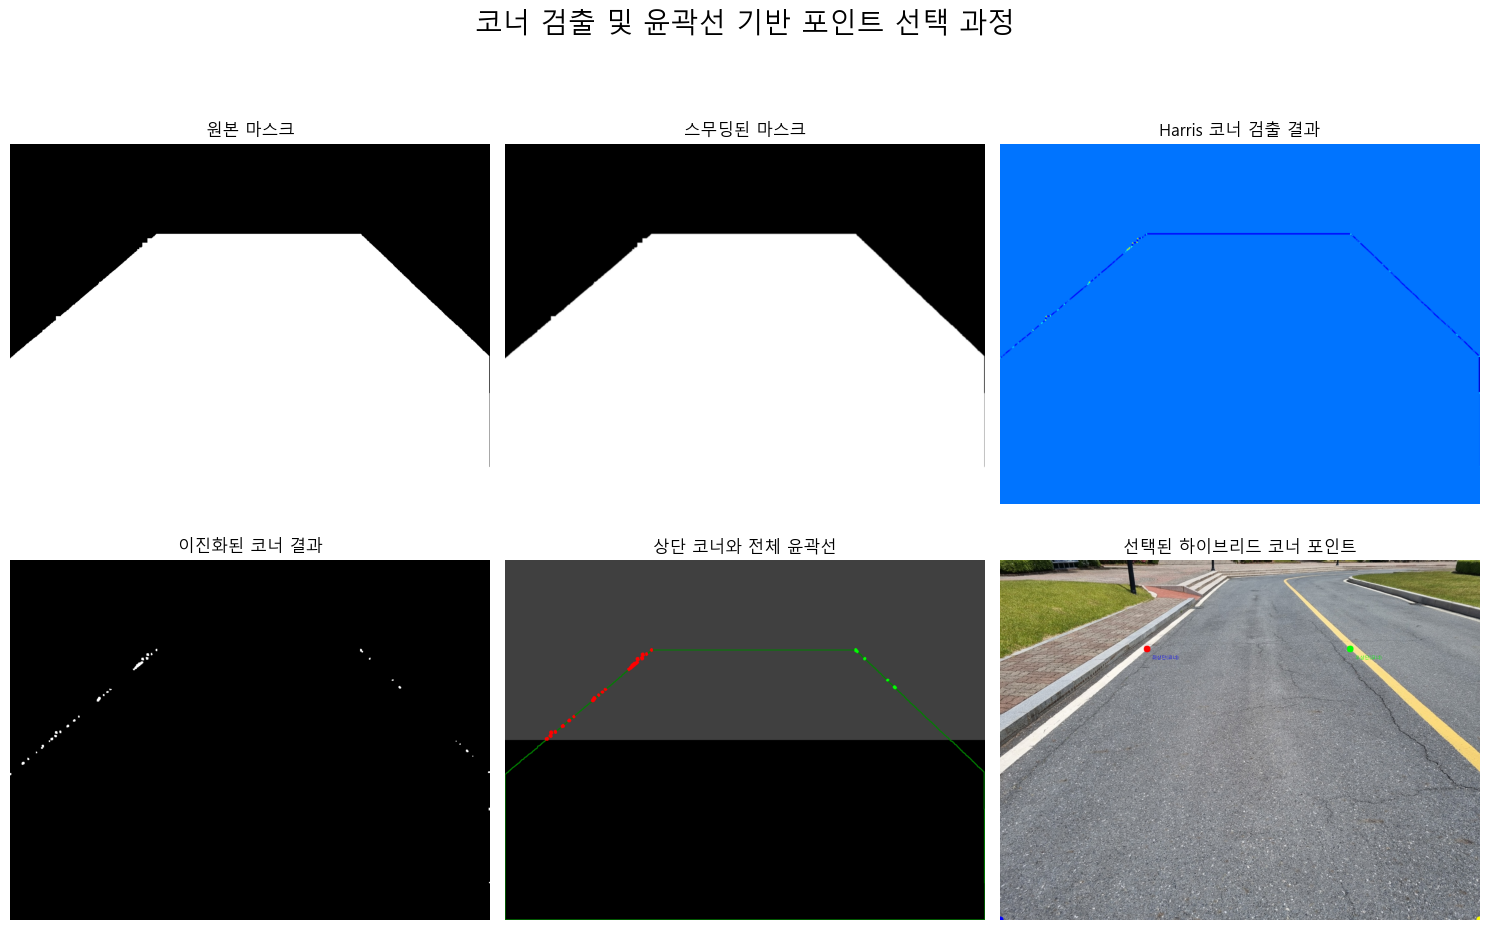


0: 768x1024 4 cracks, 1119.3ms
Speed: 8.6ms preprocess, 1119.3ms inference, 11.7ms postprocess per image at shape (1, 3, 768, 1024)


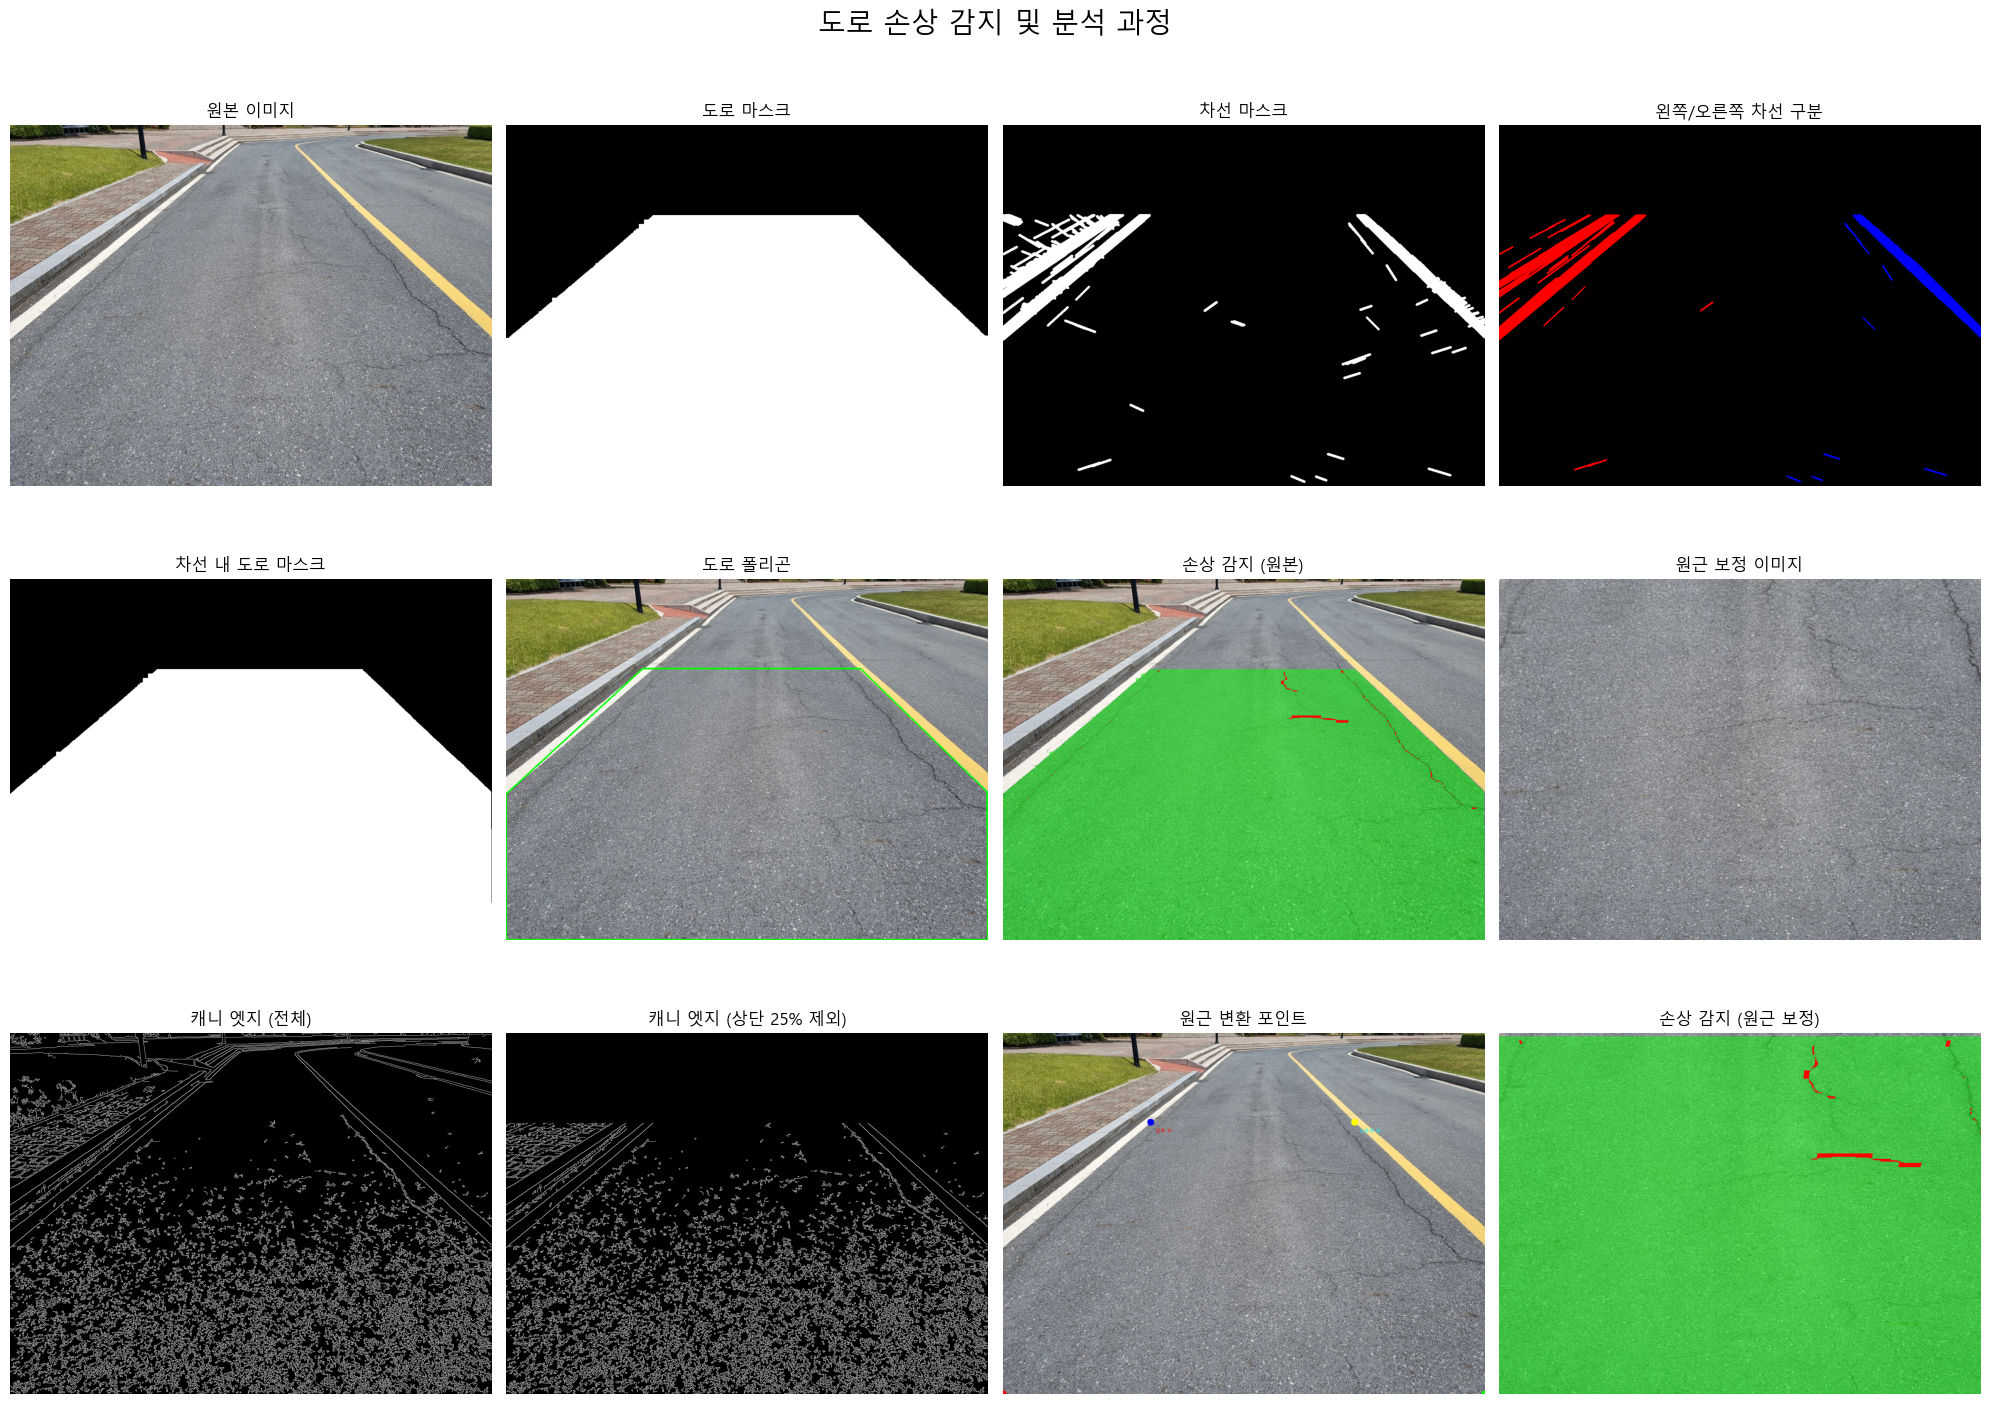


도로 영역 분석 결과:
도로 면적: 972032 픽셀
균열 면적: 5841 픽셀 (0.60%)
포트홀 면적: 0 픽셀 (0.00%)
총 손상 면적: 5841 픽셀 (0.60%)

원근 보정된 도로 영역 분석 결과:
도로 면적: 1482961 픽셀
균열 면적: 16332 픽셀 (1.10%)
포트홀 면적: 0 픽셀 (0.00%)
총 손상 면적: 16332 픽셀 (1.10%)


In [ ]:
import cv2
import torch
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from ultralytics import YOLO

# matplotlib 한글 폰트 설정
import matplotlib.font_manager as fm
import platform

def setup_matplotlib_font():
    # 운영체제별 기본 폰트 설정
    system = platform.system()
    if system == 'Windows':
        font_path = 'C:/Windows/Fonts/malgun.ttf'  # 윈도우의 경우 맑은 고딕
    elif system == 'Darwin':  # macOS
        font_path = '/System/Library/Fonts/AppleSDGothicNeo.ttc'
    else:  # Linux
        font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 우분투 기준 나눔고딕

    # 폰트 패스가 유효한지 확인
    try:
        font_prop = fm.FontProperties(fname=font_path)
        plt.rcParams['font.family'] = font_prop.get_name()
    except:
        print("기본 폰트를 사용합니다. 한글이 깨질 수 있습니다.")
        plt.rcParams['font.family'] = 'NanumGothic'  # 나눔고딕이 설치되어 있으면 사용

    # 그래프에서 마이너스 폰트 깨짐 방지
    plt.rcParams['axes.unicode_minus'] = False

def put_text_on_image(img, text, position, font_size=1, color=(255, 0, 0), thickness=2):
    """한글 텍스트를 이미지에 표시하는 함수"""
    # PIL 이미지로 변환
    pil_img = Image.fromarray(img)
    
    # 그리기 객체 생성
    draw = ImageDraw.Draw(pil_img)
    
    # 폰트 설정 (시스템에 맞게 조절 필요)
    system = platform.system()
    if system == 'Windows':
        font_path = 'C:/Windows/Fonts/malgun.ttf'  # 윈도우의 경우 맑은 고딕
    elif system == 'Darwin':  # macOS
        font_path = '/System/Library/Fonts/AppleSDGothicNeo.ttc'
    else:  # Linux
        font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 우분투 기준 나눔고딕
    
    try:
        font = ImageFont.truetype(font_path, int(font_size * 20))
    except:
        print("폰트를 로드할 수 없습니다. 기본 폰트를 사용합니다.")
        font = ImageFont.load_default()
    
    # 텍스트 그리기
    draw.text(position, text, font=font, fill=color[::-1])  # RGB -> BGR 변환
    
    # NumPy 배열로 변환하여 반환
    return np.array(pil_img)

def extract_road_mask(img):
    """도로 영역 추출 함수"""
    # HSV 변환
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # 도로 색상 범위 (회색 계열)
    lower_road = np.array([0, 0, 60])
    upper_road = np.array([180, 30, 160])
    road_mask = cv2.inRange(hsv, lower_road, upper_road)
    
    # 이미지 높이의 하단 75%만 고려 (상단 25% 제외)
    height = img.shape[0]
    road_mask[:int(height * 0.25), :] = 0
    
    # 노이즈 제거를 위한 모폴로지 연산
    kernel = np.ones((15, 15), np.uint8)
    road_mask = cv2.morphologyEx(road_mask, cv2.MORPH_CLOSE, kernel)
    road_mask = cv2.morphologyEx(road_mask, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))
    
    # 가장 큰 연결 요소만 유지
    contours, _ = cv2.findContours(road_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        max_contour = max(contours, key=cv2.contourArea)
        if cv2.contourArea(max_contour) > (height * img.shape[1] * 0.1):
            refined_mask = np.zeros_like(road_mask)
            cv2.drawContours(refined_mask, [max_contour], 0, 255, -1)
            road_mask = refined_mask
    
    return road_mask

def detect_lane_lines(img):
    """차선 감지 및 마스크 생성 함수"""
    # 그레이스케일 변환
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 가우시안 블러 및 엣지 감지
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)
    
    # ROI 설정 - 상단 25%를 제외한 영역만 고려
    height, width = edges.shape
    roi_mask = np.ones_like(edges)
    roi_mask[:int(height * 0.25), :] = 0
    masked_edges = cv2.bitwise_and(edges, edges, mask=roi_mask)
    
    # 색상 기반 차선 추출 (흰색/노란색)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # 흰색 및 노란색 범위 설정
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 30, 255])
    white_mask = cv2.inRange(hsv, lower_white, upper_white)
    
    lower_yellow = np.array([10, 60, 80])
    upper_yellow = np.array([40, 255, 255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    # 색상 마스크 통합 및 ROI 적용
    color_mask = cv2.bitwise_or(white_mask, yellow_mask)
    color_mask = cv2.bitwise_and(color_mask, color_mask, mask=roi_mask)
    
    # 최종 마스크 (엣지 + 색상)
    final_mask = cv2.bitwise_or(masked_edges, color_mask)
    
    # 호프 변환으로 직선 검출
    lines = cv2.HoughLinesP(
        final_mask, 
        rho=1, 
        theta=np.pi/180, 
        threshold=40,
        minLineLength=30,
        maxLineGap=5
    )
    
    # 차선 마스크 초기화
    lane_mask = np.zeros_like(gray)
    left_line_mask = np.zeros_like(gray)
    right_line_mask = np.zeros_like(gray)
    
    # 차선 필터링 및 분류
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            
            # 선의 길이가 너무 짧으면 무시
            if np.sqrt((x2 - x1)**2 + (y2 - y1)**2) < 30:
                continue
                
            # 기울기 계산
            if x2 - x1 == 0:  # 수직선 방지
                continue
            else:
                slope = (y2 - y1) / (x2 - x1)
            
            # 적절한 기울기 범위만 선택 (약 15도 ~ 65도 범위)
            if 0.3 < abs(slope) < 2:  
                cv2.line(lane_mask, (x1, y1), (x2, y2), 255, 3)
                
                # 왼쪽/오른쪽 차선 구분
                mid_x = width // 2
                line_mid_x = (x1 + x2) // 2
                
                if slope < 0 and line_mid_x < mid_x:  # 왼쪽 차선 (음수 기울기)
                    cv2.line(left_line_mask, (x1, y1), (x2, y2), 255, 3)
                elif slope > 0 and line_mid_x > mid_x:  # 오른쪽 차선 (양수 기울기)
                    cv2.line(right_line_mask, (x1, y1), (x2, y2), 255, 3)
    
    # 차선 마스크 확장
    kernel = np.ones((3, 3), np.uint8)
    lane_mask = cv2.dilate(lane_mask, kernel, iterations=1)
    
    return lane_mask, left_line_mask, right_line_mask, edges, masked_edges

def extract_road_between_lanes(img, road_mask, left_lane_mask, right_lane_mask):
    """차선 내부의 도로 영역 추출 함수"""
    height, width = road_mask.shape
    
    # 왼쪽과 오른쪽 차선 윤곽선 찾기
    left_contours, _ = cv2.findContours(left_lane_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    right_contours, _ = cv2.findContours(right_lane_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 차선 마스크가 충분하지 않으면 기본 도로 마스크 반환
    if not left_contours or not right_contours:
        return road_mask, None
    
    # 가장 큰 왼쪽/오른쪽 차선 윤곽선 선택
    left_contour = max(left_contours, key=cv2.contourArea) if left_contours else None
    right_contour = max(right_contours, key=cv2.contourArea) if right_contours else None
    
    if left_contour is None or right_contour is None:
        return road_mask, None
    
    # 왼쪽/오른쪽 차선의 외곽점 찾기
    left_points = left_contour.reshape(-1, 2)
    right_points = right_contour.reshape(-1, 2)
    
    # 각 차선에서 가장 아래/위 지점 찾기
    left_bottom = left_points[np.argmax(left_points[:, 1])]
    right_bottom = right_points[np.argmax(right_points[:, 1])]
    left_top = left_points[np.argmin(left_points[:, 1])]
    right_top = right_points[np.argmin(right_points[:, 1])]
    
    # 차선이 충분히 감지되지 않은 경우 대체 포인트 설정
    if np.linalg.norm(left_top - left_bottom) < 50:
        left_top[1] = max(0, height - height//3)
    
    if np.linalg.norm(right_top - right_bottom) < 50:
        right_top[1] = max(0, height - height//3)
        
    # 이미지 하단 좌표 추가
    bottom_left = [0, height-1]
    bottom_right = [width-1, height-1]
    
    # 도로 폴리곤 생성 (차선 내부 + 차선 아래 영역)
    road_polygon = np.array([
        bottom_left, left_bottom, left_top, right_top, right_bottom, bottom_right
    ], dtype=np.int32)
    
    # 도로 영역 마스크 생성
    lane_road_mask = np.zeros_like(road_mask)
    cv2.fillPoly(lane_road_mask, [road_polygon], 255)
    
    # 원래 도로 마스크와 교차
    final_road_mask = cv2.bitwise_and(road_mask, lane_road_mask)
    
    return final_road_mask, road_polygon

def get_default_perspective_points(road_polygon, height, width):
    """road_polygon이 있을 경우 사용하고, 없으면 기본값 설정"""
    if road_polygon is not None and len(road_polygon) >= 6:
        # road_polygon에서 필요한 포인트 추출
        left_bottom = road_polygon[1]  # 왼쪽 차선 하단
        right_bottom = road_polygon[4] # 오른쪽 차선 하단
        left_top = road_polygon[2]     # 왼쪽 차선 상단
        right_top = road_polygon[3]    # 오른쪽 차선 상단
        
        # 사용할 코너 포인트
        return np.float32([left_bottom, right_bottom, left_top, right_top])
    else:
        # 기본값 설정
        bottom_left = np.array([0, height-1])
        bottom_right = np.array([width-1, height-1])
        top_left = np.array([width//4, height//3])
        top_right = np.array([width*3//4, height//3])
        
        return np.float32([bottom_left, bottom_right, top_left, top_right])

def perspective_transform(img, mask, road_polygon=None):
    """
    원근 변환 함수 - 상단 포인트는 코너 특징점으로, 하단 포인트는 기존 방식으로 찾기
    """
    height, width = mask.shape
    
    # 상단 포인트용 코너 검출에 적합한 마스크 준비
    mask_smooth = cv2.GaussianBlur(mask, (5, 5), 0)
    
    # Harris 코너 검출
    corners = cv2.cornerHarris(mask_smooth, blockSize=5, ksize=3, k=0.04)
    
    # 코너 검출 결과를 이진화하고 팽창 (더 뚜렷하게)
    corners_dilated = cv2.dilate(corners, None)
    _, corners_binary = cv2.threshold(corners_dilated, 0.01 * corners_dilated.max(), 255, 0)
    corners_binary = np.uint8(corners_binary)

    # 코너 포인트 좌표 추출
    corner_coords = np.where(corners_binary > 0)
    corner_y = corner_coords[0]
    corner_x = corner_coords[1]
    
    # 모든 코너 좌표를 리스트로 변환
    all_corners = []
    for i in range(len(corner_y)):
        all_corners.append([corner_x[i], corner_y[i]])
    
    # 코너가 충분히 많지 않으면 대체 방식 사용
    if len(all_corners) < 10:
        return fallback_perspective_transform(img, mask, road_polygon)
    
    # 이미지를 4분할하여 상단 영역에서 코너점 찾기
    h_mid = height // 2
    w_mid = width // 2
    
    # 상단 영역의 코너 포인트
    top_left_corners = [p for p in all_corners if p[0] < w_mid and p[1] < h_mid]
    top_right_corners = [p for p in all_corners if p[0] >= w_mid and p[1] < h_mid]
    
    # 상단 영역에 코너가 없는 경우 대체 방법 사용
    if not (top_left_corners and top_right_corners):
        return fallback_perspective_transform(img, mask, road_polygon)
    
    # 좌상단: 원점에서 가장 가까운 포인트
    top_left = min(top_left_corners, key=lambda p: (p[0]-w_mid)**2 + p[1]**2)
    
    # 우상단: (width, 0)에서 가장 가까운 포인트
    top_right = min(top_right_corners, key=lambda p: (p[0]-w_mid)**2 + p[1]**2)
    
    # 하단 포인트는 기존 방식으로 찾기
    # 도로 마스크에서 윤곽선 찾기
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours or len(contours) == 0:
        return fallback_perspective_transform(img, mask, road_polygon)
    
    # 가장 큰 윤곽선 선택
    main_contour = max(contours, key=cv2.contourArea)
    all_points = main_contour.reshape(-1, 2)
    
    if len(all_points) == 0:
        return fallback_perspective_transform(img, mask, road_polygon)
    
    # 왼쪽 하단: x값 최소, y값 최대
    left_bottom_idx = np.lexsort((all_points[:, 0], -all_points[:, 1]))[0]
    bottom_left = all_points[left_bottom_idx]
    
    # 오른쪽 하단: x값 최대, y값 최대
    right_bottom_idx = np.lexsort((-all_points[:, 0], -all_points[:, 1]))[0]
    bottom_right = all_points[right_bottom_idx]
    
    # 포인트 추가 검증: y 좌표가 위아래 구분에 맞게 정렬
    if top_left[1] > bottom_left[1] or top_right[1] > bottom_right[1]:
        return fallback_perspective_transform(img, mask, road_polygon)
    
    # 포인트 추가 검증: x 좌표가 좌우 구분에 맞게 정렬
    if top_left[0] > top_right[0] or bottom_left[0] > bottom_right[0]:
        return fallback_perspective_transform(img, mask, road_polygon)
    
    # 원근 변환에 사용할 소스 포인트
    src_points = np.float32([
        bottom_left,    # 좌하단
        bottom_right,   # 우하단
        top_left,       # 좌상단
        top_right       # 우상단
    ])
    
    # 타겟 포인트 설정 (변환 후 이미지에서의 위치)
    dst_points = np.float32([
        [0, height-1],               # 왼쪽 하단
        [width-1, height-1],         # 오른쪽 하단
        [0, 0],                      # 왼쪽 상단
        [width-1, 0]                 # 오른쪽 상단
    ])
    
    # 원근 변환 행렬 계산 및 적용
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    warped_img = cv2.warpPerspective(img, M, (width, height))
    warped_mask = cv2.warpPerspective(mask, M, (width, height))
    
    return warped_img, warped_mask, M, src_points

def fallback_perspective_transform(img, mask, road_polygon=None):
    """
    코너 검출이 실패했을 때 사용하는 대체 원근 변환 함수
    기존의 방식을 사용
    """
    height, width = mask.shape
    
    # 도로 마스크에서 윤곽선 찾기
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours and len(contours) > 0:
        # 가장 큰 윤곽선 선택
        main_contour = max(contours, key=cv2.contourArea)
        all_points = main_contour.reshape(-1, 2)
        
        if len(all_points) > 0:
            # 왼쪽 하단: x값 최소, y값 최대
            left_bottom_idx = np.lexsort((all_points[:, 0], -all_points[:, 1]))[0]
            left_bottom = all_points[left_bottom_idx]
            
            # 오른쪽 하단: x값 최대, y값 최대
            right_bottom_idx = np.lexsort((-all_points[:, 0], -all_points[:, 1]))[0]
            right_bottom = all_points[right_bottom_idx]
            
            # 상단 부분의 포인트 추출 (y값이 하위 10% 이내인 점들)
            y_threshold = np.percentile(all_points[:, 1], 10)
            top_points = all_points[all_points[:, 1] <= y_threshold]
            
            if len(top_points) > 0:
                # 왼쪽 상단: 상단 부분에서 x값이 가장 작은 점
                left_top_idx = np.argmin(top_points[:, 0])
                left_top = top_points[left_top_idx]
                
                # 오른쪽 상단: 상단 부분에서 x값이 가장 큰 점
                right_top_idx = np.argmax(top_points[:, 0])
                right_top = top_points[right_top_idx]
            else:
                # 상단 부분 포인트가 부족한 경우, y값을 우선 정렬하여 가장 작은 y값을 가진 포인트 중에서 선택
                sorted_by_y = all_points[np.argsort(all_points[:, 1])]
                top_n_points = sorted_by_y[:max(5, len(sorted_by_y) // 10)]  # 상위 10% 또는 최소 5개
                
                # 이 포인트들 중에서 왼쪽/오른쪽 구분
                left_top_idx = np.argmin(top_n_points[:, 0])
                left_top = top_n_points[left_top_idx]
                
                right_top_idx = np.argmax(top_n_points[:, 0])
                right_top = top_n_points[right_top_idx]
            
            src_points = np.float32([left_bottom, right_bottom, left_top, right_top])
        else:
            # 포인트가 없는 경우 기본값 사용
            src_points = get_default_perspective_points(road_polygon, height, width)
    else:
        # 윤곽선이 없는 경우 기본값 사용
        src_points = get_default_perspective_points(road_polygon, height, width)
    
    # 타겟 포인트 설정 (변환 후 이미지에서의 위치)
    dst_points = np.float32([
        [0, height-1],               # 왼쪽 하단
        [width-1, height-1],         # 오른쪽 하단
        [0, 0],                      # 왼쪽 상단
        [width-1, 0]                 # 오른쪽 상단
    ])
    
    # 원근 변환 행렬 계산 및 적용
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    warped_img = cv2.warpPerspective(img, M, (width, height))
    warped_mask = cv2.warpPerspective(mask, M, (width, height))
    
    return warped_img, warped_mask, M, src_points

def apply_yolo_on_masked_area(model, img, mask):
    """마스크된 영역에서 YOLO 추론 수행"""
    # 마스크를 3채널로 확장
    mask_3ch = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    
    # 마스크 적용된 이미지 생성
    masked_img = cv2.bitwise_and(img, mask_3ch)
    
    # YOLO 추론
    results = model(masked_img)
    res = results[0]
    
    # 클래스별 마스크 생성
    mask_crack = np.zeros(img.shape[:2], dtype=np.uint8)
    mask_pothole = np.zeros(img.shape[:2], dtype=np.uint8)
    
    for i, box in enumerate(res.boxes):
        cls = int(box.cls[0])
        if i < len(res.masks):  # 안전하게 인덱스 확인
            single_mask = res.masks.data[i].cpu().numpy()
            binary_mask = (single_mask > 0.5).astype(np.uint8) * 255
            binary_mask_resized = cv2.resize(binary_mask, (img.shape[1], img.shape[0]))
            
            if cls == 0:  # crack
                mask_crack = cv2.bitwise_or(mask_crack, binary_mask_resized)
            elif cls == 1:  # pothole
                mask_pothole = cv2.bitwise_or(mask_pothole, binary_mask_resized)
    
    return mask_crack, mask_pothole

def visualize_corner_detection(img, mask):
    """코너 검출 과정과 결과를 시각화하는 함수 - 하이브리드 방식 시각화"""
    height, width = mask.shape
    
    # 코너 검출에 사용된 마스크 준비
    mask_smooth = cv2.GaussianBlur(mask, (5, 5), 0)
    
    # Harris 코너 검출
    corners = cv2.cornerHarris(mask_smooth, blockSize=5, ksize=3, k=0.04)
    
    # 결과 이진화 및 팽창
    corners_dilated = cv2.dilate(corners, None)
    _, corners_binary = cv2.threshold(corners_dilated, 0.01 * corners_dilated.max(), 255, 0)
    corners_binary = np.uint8(corners_binary)

    # 코너 좌표 추출
    corner_coords = np.where(corners_binary > 0)
    all_corners = []
    for i in range(len(corner_coords[0])):
        all_corners.append([corner_coords[1][i], corner_coords[0][i]])  # x, y 순서로 저장
    
    # 이미지 상단/하단 구분
    h_mid = height // 2
    w_mid = width // 2
    
    # 상단 영역의 코너 포인트 분류
    top_left_corners = [p for p in all_corners if p[0] < w_mid and p[1] < h_mid]
    top_right_corners = [p for p in all_corners if p[0] >= w_mid and p[1] < h_mid]
    
    # 최적의 상단 코너 포인트 계산
    selected_corners = []
    if top_left_corners:
        top_left = min(top_left_corners, key=lambda p: (p[0]-w_mid)**2 + p[1]**2)
        selected_corners.append(top_left)
    
    if top_right_corners:
        top_right = min(top_right_corners, key=lambda p: (p[0]-w_mid)**2 + p[1]**2)
        selected_corners.append(top_right)
    
    # 하단 포인트 계산 (기존 방식)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours and len(contours) > 0:
        main_contour = max(contours, key=cv2.contourArea)
        all_points = main_contour.reshape(-1, 2)
        
        if len(all_points) > 0:
            # 왼쪽 하단: x값 최소, y값 최대
            left_bottom_idx = np.lexsort((all_points[:, 0], -all_points[:, 1]))[0]
            bottom_left = all_points[left_bottom_idx]
            selected_corners.append(bottom_left)
            
            # 오른쪽 하단: x값 최대, y값 최대
            right_bottom_idx = np.lexsort((-all_points[:, 0], -all_points[:, 1]))[0]
            bottom_right = all_points[right_bottom_idx]
            selected_corners.append(bottom_right)
    
# 시각화
    plt.figure(figsize=(15, 10))
    
    # 원본 마스크
    plt.subplot(2, 3, 1)
    plt.imshow(mask, cmap='gray')
    plt.title('원본 마스크')
    plt.axis('off')
    
    # 스무딩된 마스크
    plt.subplot(2, 3, 2)
    plt.imshow(mask_smooth, cmap='gray')
    plt.title('스무딩된 마스크')
    plt.axis('off')
    
    # Harris 코너 검출 결과
    plt.subplot(2, 3, 3)
    plt.imshow(corners, cmap='jet')
    plt.title('Harris 코너 검출 결과')
    plt.axis('off')
    
    # 이진화된 코너 결과
    plt.subplot(2, 3, 4)
    plt.imshow(corners_binary, cmap='gray')
    plt.title('이진화된 코너 결과')
    plt.axis('off')
    
    # 상단 코너와 윤곽선 구분
    plt.subplot(2, 3, 5)
    visualization = np.zeros((height, width, 3), dtype=np.uint8)
    
    # 상단 영역 표시 (밝은 회색)
    visualization[:h_mid, :] = [64, 64, 64]
    
    # 윤곽선 표시
    if contours and len(contours) > 0:
        cv2.drawContours(visualization, [main_contour], 0, [0, 128, 0], 2)
    
    # 상단 코너 표시
    for p in top_left_corners:
        cv2.circle(visualization, tuple(p), 2, [255, 0, 0], -1)  # 빨간색
    for p in top_right_corners:
        cv2.circle(visualization, tuple(p), 2, [0, 255, 0], -1)  # 초록색
    
    plt.imshow(visualization)
    plt.title('상단 코너와 전체 윤곽선')
    plt.axis('off')
    
    # 선택된 코너 포인트
    plt.subplot(2, 3, 6)
    img_with_corners = img.copy()
    point_names = ['좌상단(코너)', '우상단(코너)', '좌하단(윤곽선)', '우하단(윤곽선)']
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]
    
    for i, p in enumerate(selected_corners):
        if i < len(point_names):
            cv2.circle(img_with_corners, tuple(p), 10, colors[i], -1)
            # PIL로 한글 텍스트 추가
            img_with_corners = put_text_on_image(
                img_with_corners, 
                point_names[i], 
                (p[0] + 15, p[1] + 15), 
                font_size=0.7, 
                color=colors[i]
            )
    
    plt.imshow(img_with_corners)
    plt.title('선택된 하이브리드 코너 포인트')
    plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle("코너 검출 및 윤곽선 기반 포인트 선택 과정", fontsize=20)
    plt.subplots_adjust(top=0.9)
    plt.show()

def visualize_results(original_img, road_mask, lane_mask, left_lane_mask, right_lane_mask,
                     road_lane_mask, road_polygon, mask_crack, mask_pothole, 
                     warped_img, warped_mask, warped_crack, warped_pothole, corner_points,
                     edges, masked_edges):
    """결과 시각화 함수"""
    plt.figure(figsize=(20, 15))
    
    # 첫 번째 행: 기본 이미지와 마스크
    plt.subplot(3, 4, 1)
    plt.imshow(original_img)
    plt.title('원본 이미지')
    plt.axis('off')
    
    plt.subplot(3, 4, 2)
    plt.imshow(road_mask, cmap='gray')
    plt.title('도로 마스크')
    plt.axis('off')
    
    plt.subplot(3, 4, 3)
    plt.imshow(lane_mask, cmap='gray')
    plt.title('차선 마스크')
    plt.axis('off')
    
    # 왼쪽/오른쪽 차선 구분
    plt.subplot(3, 4, 4)
    lane_combined = np.zeros((original_img.shape[0], original_img.shape[1], 3), dtype=np.uint8)
    lane_combined[left_lane_mask == 255] = [255, 0, 0]  # 왼쪽 차선: 빨간색
    lane_combined[right_lane_mask == 255] = [0, 0, 255]  # 오른쪽 차선: 파란색
    plt.imshow(lane_combined)
    plt.title('왼쪽/오른쪽 차선 구분')
    plt.axis('off')
    
    # 두 번째 행: 도로 분석
    plt.subplot(3, 4, 5)
    plt.imshow(road_lane_mask, cmap='gray')
    plt.title('차선 내 도로 마스크')
    plt.axis('off')
    
    plt.subplot(3, 4, 6)
    polygon_viz = original_img.copy()
    cv2.polylines(polygon_viz, [road_polygon], True, (0, 255, 0), 3)
    plt.imshow(polygon_viz)
    plt.title('도로 폴리곤')
    plt.axis('off')
    
    # 손상 감지 시각화
    plt.subplot(3, 4, 7)
    overlay_original = original_img.copy()
    alpha = 0.5
    road_overlay = overlay_original.copy()
    road_overlay[road_lane_mask == 255] = [0, 255, 0]  # 도로: 초록색
    overlay_original = cv2.addWeighted(road_overlay, alpha, overlay_original, 1-alpha, 0)
    overlay_original[mask_crack == 255] = [255, 0, 0]  # 균열: 빨간색
    overlay_original[mask_pothole == 255] = [0, 0, 255]  # 포트홀: 파란색
    plt.imshow(overlay_original)
    plt.title('손상 감지 (원본)')
    plt.axis('off')
    
    plt.subplot(3, 4, 8)
    plt.imshow(warped_img)
    plt.title('원근 보정 이미지')
    plt.axis('off')
    
    # 세 번째 행: 추가 분석
    plt.subplot(3, 4, 9)
    plt.imshow(edges, cmap='gray')
    plt.title('캐니 엣지 (전체)')
    plt.axis('off')
    
    plt.subplot(3, 4, 10)
    plt.imshow(masked_edges, cmap='gray')
    plt.title('캐니 엣지 (상단 25% 제외)')
    plt.axis('off')
    
    # 원근 변환 포인트 시각화
    plt.subplot(3, 4, 11)
    img_with_points = original_img.copy()
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]
    point_names = ['왼쪽 아래', '오른쪽 아래', '왼쪽 위', '오른쪽 위']
    
    for i, point in enumerate(corner_points):
        cv2.circle(img_with_points, (int(point[0]), int(point[1])), 10, colors[i], -1)
        # PIL로 한글 텍스트 추가
        img_with_points = put_text_on_image(
            img_with_points, 
            point_names[i], 
            (int(point[0]) + 15, int(point[1]) + 15), 
            font_size=0.7, 
            color=colors[i]
        )
    plt.imshow(img_with_points)
    plt.title('원근 변환 포인트')
    plt.axis('off')
    
    # 원근 보정된 손상 감지
    plt.subplot(3, 4, 12)
    overlay_warped = warped_img.copy()
    road_overlay_warped = overlay_warped.copy()
    road_overlay_warped[warped_mask == 255] = [0, 255, 0]
    overlay_warped = cv2.addWeighted(road_overlay_warped, alpha, overlay_warped, 1-alpha, 0)
    overlay_warped[warped_crack == 255] = [255, 0, 0]
    overlay_warped[warped_pothole == 255] = [0, 0, 255]
    plt.imshow(overlay_warped)
    plt.title('손상 감지 (원근 보정)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle("도로 손상 감지 및 분석 과정", fontsize=20)
    plt.subplots_adjust(top=0.95)
    plt.show()
    
    # 손상 면적 계산 및 출력
    road_area = np.count_nonzero(road_lane_mask)
    crack_area = np.count_nonzero(cv2.bitwise_and(mask_crack, road_lane_mask))
    pothole_area = np.count_nonzero(cv2.bitwise_and(mask_pothole, road_lane_mask))
    
    print(f"\n도로 영역 분석 결과:")
    print(f"도로 면적: {road_area} 픽셀")
    print(f"균열 면적: {crack_area} 픽셀 ({crack_area/road_area*100:.2f}%)")
    print(f"포트홀 면적: {pothole_area} 픽셀 ({pothole_area/road_area*100:.2f}%)")
    print(f"총 손상 면적: {crack_area + pothole_area} 픽셀 ({(crack_area + pothole_area)/road_area*100:.2f}%)")

    # 원근 보정된 이미지에서의 손상 면적 계산 및 출력
    warped_road_area = np.count_nonzero(warped_mask)
    warped_crack_area = np.count_nonzero(cv2.bitwise_and(warped_crack, warped_mask))
    warped_pothole_area = np.count_nonzero(cv2.bitwise_and(warped_pothole, warped_mask))
    
    print(f"\n원근 보정된 도로 영역 분석 결과:")
    print(f"도로 면적: {warped_road_area} 픽셀")
    print(f"균열 면적: {warped_crack_area} 픽셀 ({warped_crack_area/warped_road_area*100:.2f}%)")
    print(f"포트홀 면적: {warped_pothole_area} 픽셀 ({warped_pothole_area/warped_road_area*100:.2f}%)")
    print(f"총 손상 면적: {warped_crack_area + warped_pothole_area} 픽셀 ({(warped_crack_area + warped_pothole_area)/warped_road_area*100:.2f}%)")

def main():
    # 폰트 설정
    setup_matplotlib_font()
    
    # 모델 로드
    model_path = './model/yolo11l-seg.pt'
    model = YOLO(model_path)
    print(f"YOLOv11-seg 모델 '{model_path}'을(를) 로드했습니다.")
    
    # 이미지 로드
    img_num = input("테스트할 이미지 번호를 입력하세요: ")
    img_path = f'./image/test_image_{img_num}.jpg'
    print(f"이미지 '{img_path}'을(를) 로드했습니다.")
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_height, img_width = img_rgb.shape[:2]
    
    # 도로 마스크 생성
    road_mask = extract_road_mask(img_bgr)
    
    # 차선 마스크 생성
    lane_mask, left_lane_mask, right_lane_mask, edges, masked_edges = detect_lane_lines(img_bgr)
    
    # 차선 내부의 도로와 아래 부분까지 마스크
    road_lane_mask, road_polygon = extract_road_between_lanes(img_bgr, road_mask, left_lane_mask, right_lane_mask)
    
    # 코너 검출 과정 시각화 (선택 사항)
    visualize_corner_detection(img_rgb, road_lane_mask)
    
    # 마스크된 영역에서 YOLO 추론
    mask_crack, mask_pothole = apply_yolo_on_masked_area(model, img_rgb, road_lane_mask)
    
    # 원근 변환 적용 - road_lane_mask를 사용
    warped_img, warped_mask, perspective_matrix, corner_points = perspective_transform(
        img_rgb, road_lane_mask, road_polygon)
    
    # 손상 마스크에도 원근 변환 적용
    warped_crack = cv2.warpPerspective(mask_crack, perspective_matrix, (img_width, img_height))
    warped_pothole = cv2.warpPerspective(mask_pothole, perspective_matrix, (img_width, img_height))
    
    # 결과 시각화
    visualize_results(
        img_rgb, road_mask, lane_mask, left_lane_mask, right_lane_mask,
        road_lane_mask, road_polygon, mask_crack, mask_pothole, 
        warped_img, warped_mask, warped_crack, warped_pothole, corner_points,
        edges, masked_edges
    )

if __name__ == "__main__":
    main()

# 결과 저장 추가

YOLOv11-seg 모델 '../model/yolo11l-seg.pt'을(를) 로드했습니다.
이미지 '../image/test_image_05.jpg'을(를) 로드했습니다.


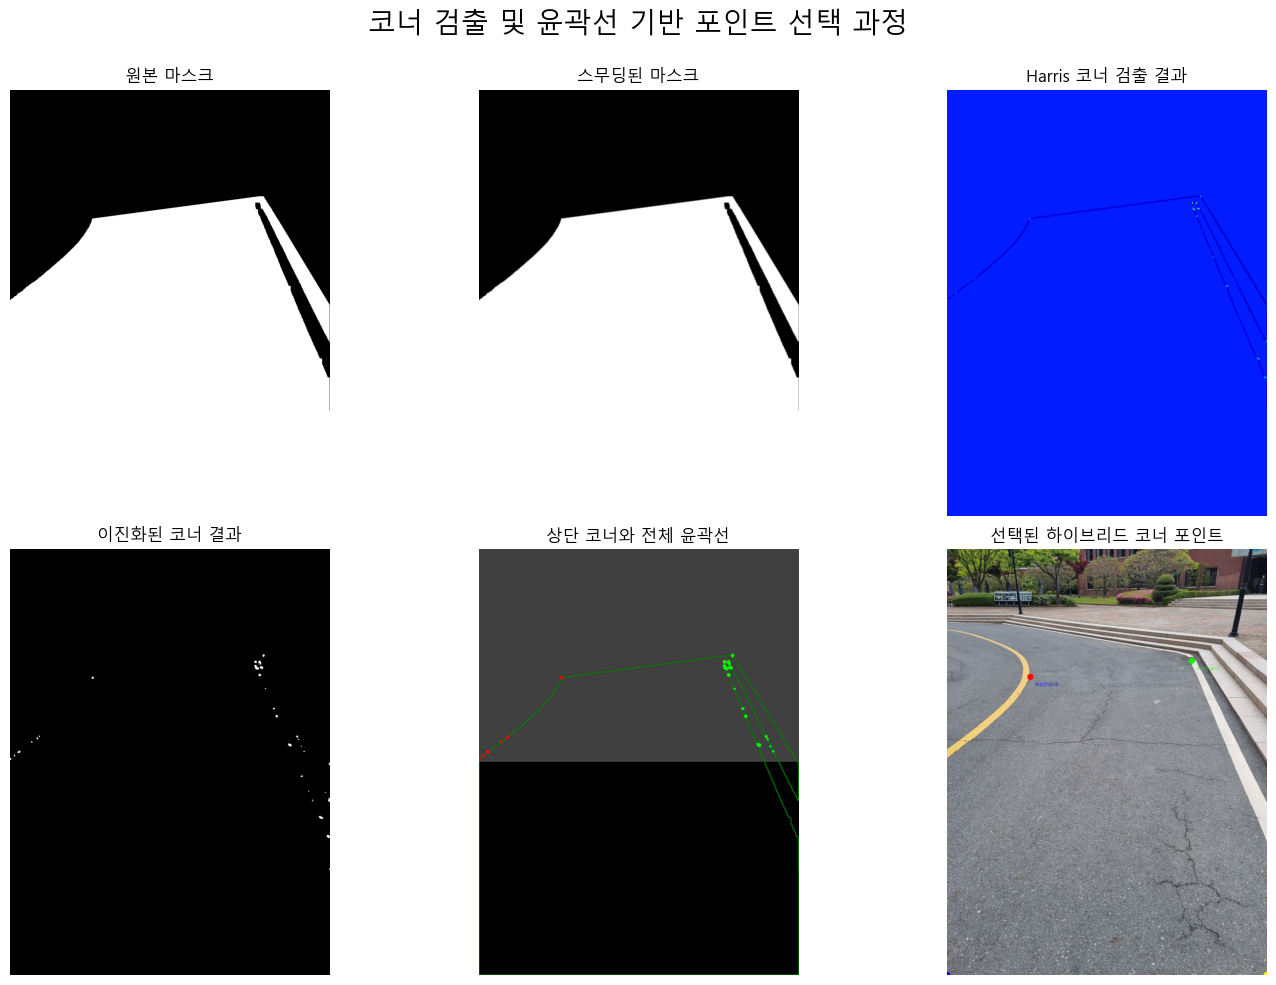


0: 1024x768 9 cracks, 1245.1ms
Speed: 6.4ms preprocess, 1245.1ms inference, 28.4ms postprocess per image at shape (1, 3, 1024, 768)


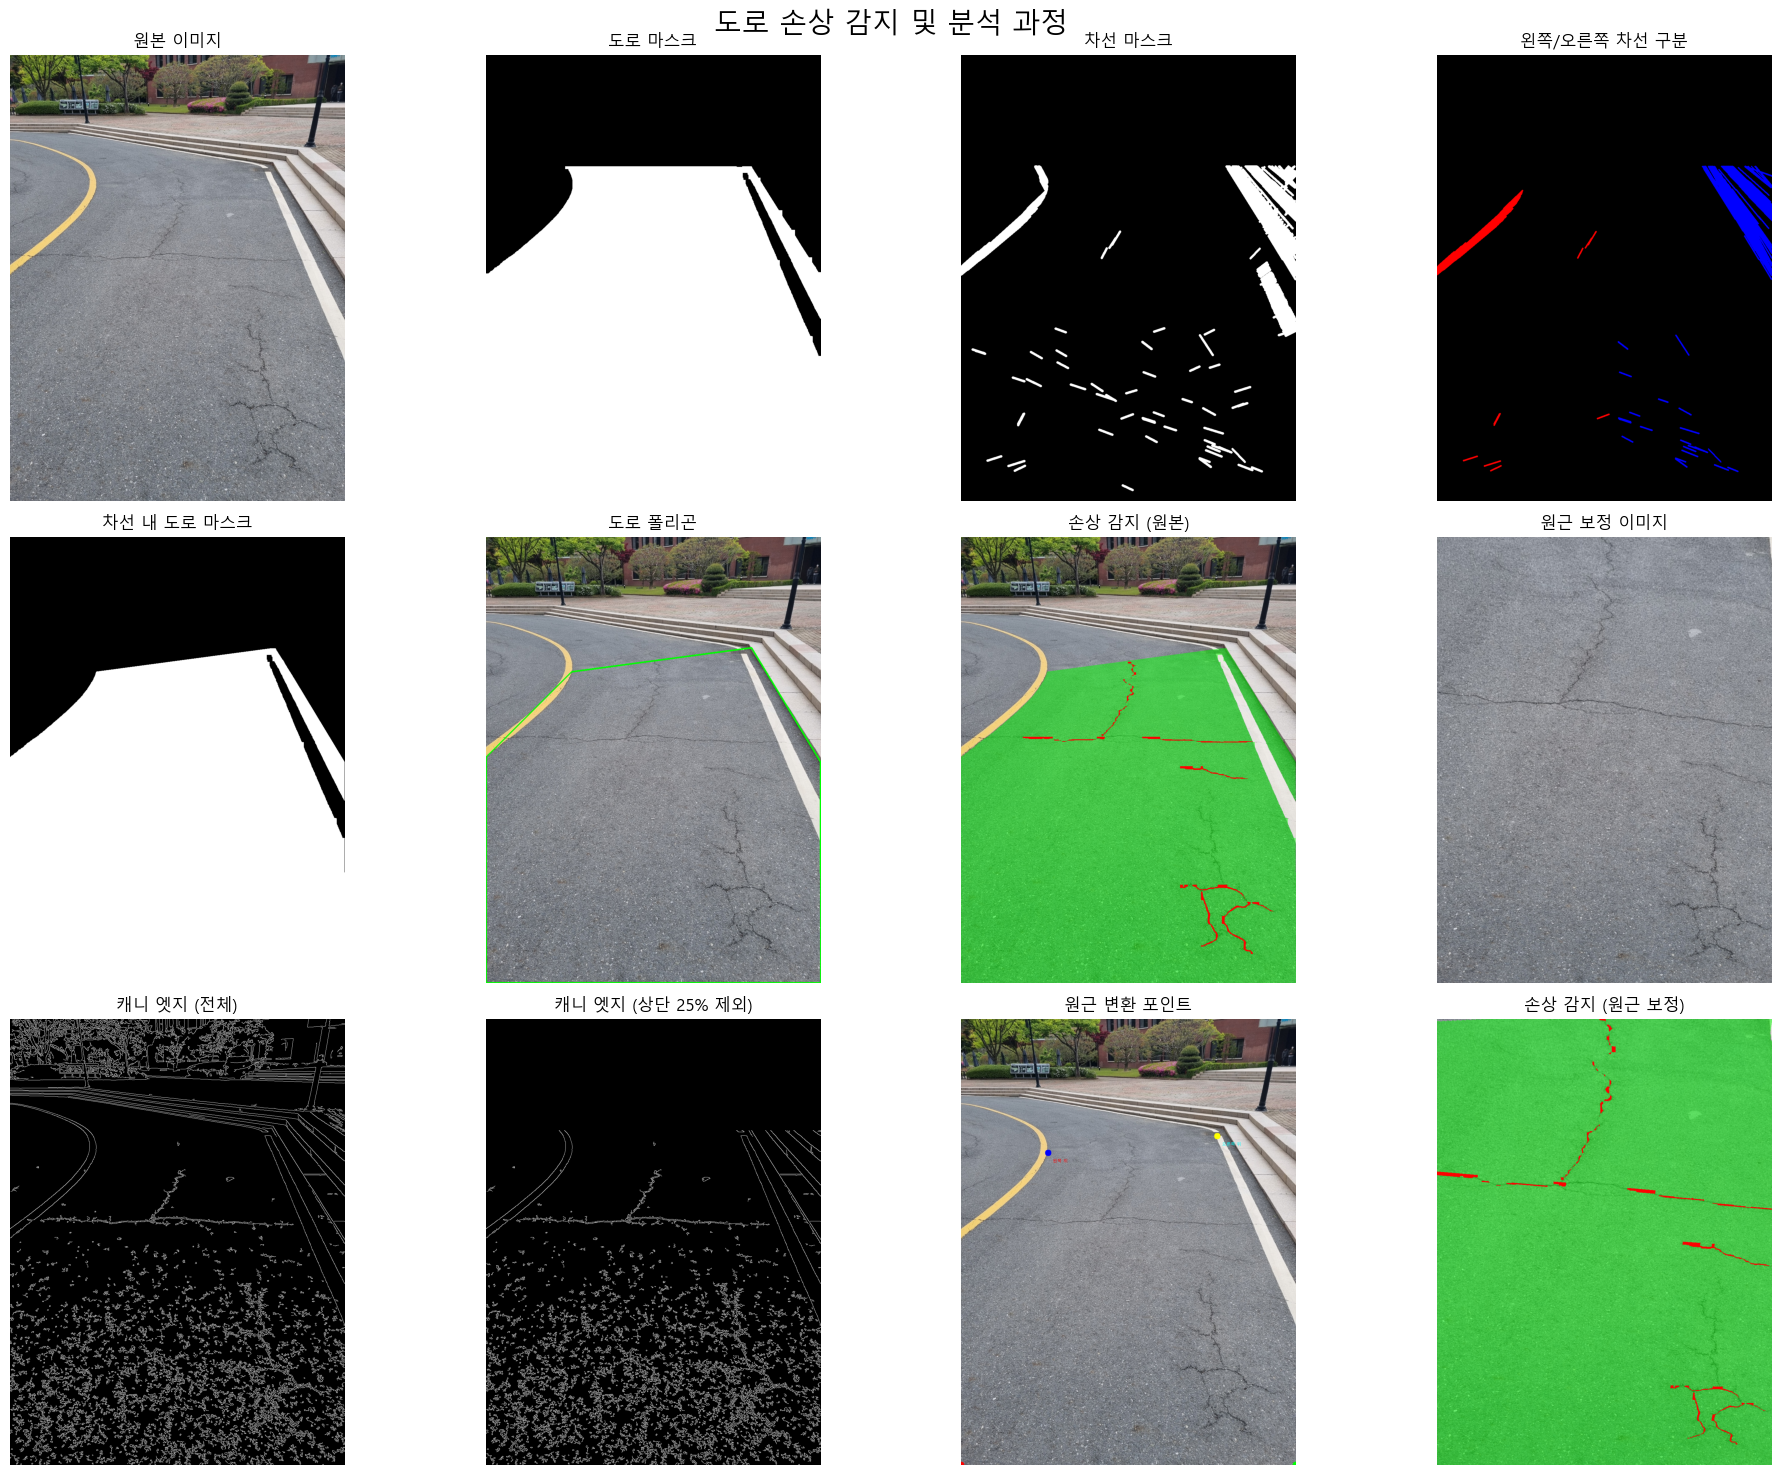


도로 영역 분석 결과:
도로 면적: 976754 픽셀
균열 면적: 14509 픽셀 (1.49%)
포트홀 면적: 0 픽셀 (0.00%)
총 손상 면적: 14509 픽셀 (1.49%)

원근 보정된 도로 영역 분석 결과:
도로 면적: 1492553 픽셀
균열 면적: 33261 픽셀 (2.23%)
포트홀 면적: 0 픽셀 (0.00%)
총 손상 면적: 33261 픽셀 (2.23%)
분석 결과가 ../result/analysis_result_05.txt에 저장되었습니다.
핵심 이미지가 ../result/key_images_05.jpg에 저장되었습니다.


In [1]:
import cv2
import torch
import numpy as np
import os
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from ultralytics import YOLO

# matplotlib 한글 폰트 설정
import matplotlib.font_manager as fm
import platform

def setup_matplotlib_font():
    # 운영체제별 기본 폰트 설정
    system = platform.system()
    if system == 'Windows':
        font_path = 'C:/Windows/Fonts/malgun.ttf'  # 윈도우의 경우 맑은 고딕
    elif system == 'Darwin':  # macOS
        font_path = '/System/Library/Fonts/AppleSDGothicNeo.ttc'
    else:  # Linux
        font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 우분투 기준 나눔고딕

    # 폰트 패스가 유효한지 확인
    try:
        font_prop = fm.FontProperties(fname=font_path)
        plt.rcParams['font.family'] = font_prop.get_name()
    except:
        print("기본 폰트를 사용합니다. 한글이 깨질 수 있습니다.")
        plt.rcParams['font.family'] = 'NanumGothic'  # 나눔고딕이 설치되어 있으면 사용

    # 그래프에서 마이너스 폰트 깨짐 방지
    plt.rcParams['axes.unicode_minus'] = False

def put_text_on_image(img, text, position, font_size=1, color=(255, 0, 0), thickness=2):
    """한글 텍스트를 이미지에 표시하는 함수"""
    # PIL 이미지로 변환
    pil_img = Image.fromarray(img)
    
    # 그리기 객체 생성
    draw = ImageDraw.Draw(pil_img)
    
    # 폰트 설정 (시스템에 맞게 조절 필요)
    system = platform.system()
    if system == 'Windows':
        font_path = 'C:/Windows/Fonts/malgun.ttf'  # 윈도우의 경우 맑은 고딕
    elif system == 'Darwin':  # macOS
        font_path = '/System/Library/Fonts/AppleSDGothicNeo.ttc'
    else:  # Linux
        font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 우분투 기준 나눔고딕
    
    try:
        font = ImageFont.truetype(font_path, int(font_size * 20))
    except:
        print("폰트를 로드할 수 없습니다. 기본 폰트를 사용합니다.")
        font = ImageFont.load_default()
    
    # 텍스트 그리기
    draw.text(position, text, font=font, fill=color[::-1])  # RGB -> BGR 변환
    
    # NumPy 배열로 변환하여 반환
    return np.array(pil_img)

def extract_road_mask(img):
    """도로 영역 추출 함수"""
    # HSV 변환
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # 도로 색상 범위 (회색 계열)
    lower_road = np.array([0, 0, 60])
    upper_road = np.array([180, 30, 160])
    road_mask = cv2.inRange(hsv, lower_road, upper_road)
    
    # 이미지 높이의 하단 75%만 고려 (상단 25% 제외)
    height = img.shape[0]
    road_mask[:int(height * 0.25), :] = 0
    
    # 노이즈 제거를 위한 모폴로지 연산
    kernel = np.ones((15, 15), np.uint8)
    road_mask = cv2.morphologyEx(road_mask, cv2.MORPH_CLOSE, kernel)
    road_mask = cv2.morphologyEx(road_mask, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))
    
    # 가장 큰 연결 요소만 유지
    contours, _ = cv2.findContours(road_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        max_contour = max(contours, key=cv2.contourArea)
        if cv2.contourArea(max_contour) > (height * img.shape[1] * 0.1):
            refined_mask = np.zeros_like(road_mask)
            cv2.drawContours(refined_mask, [max_contour], 0, 255, -1)
            road_mask = refined_mask
    
    return road_mask

def detect_lane_lines(img):
    """차선 감지 및 마스크 생성 함수"""
    # 그레이스케일 변환
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 가우시안 블러 및 엣지 감지
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)
    
    # ROI 설정 - 상단 25%를 제외한 영역만 고려
    height, width = edges.shape
    roi_mask = np.ones_like(edges)
    roi_mask[:int(height * 0.25), :] = 0
    masked_edges = cv2.bitwise_and(edges, edges, mask=roi_mask)
    
    # 색상 기반 차선 추출 (흰색/노란색)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # 흰색 및 노란색 범위 설정
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 30, 255])
    white_mask = cv2.inRange(hsv, lower_white, upper_white)
    
    lower_yellow = np.array([10, 60, 80])
    upper_yellow = np.array([40, 255, 255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    # 색상 마스크 통합 및 ROI 적용
    color_mask = cv2.bitwise_or(white_mask, yellow_mask)
    color_mask = cv2.bitwise_and(color_mask, color_mask, mask=roi_mask)
    
    # 최종 마스크 (엣지 + 색상)
    final_mask = cv2.bitwise_or(masked_edges, color_mask)
    
    # 호프 변환으로 직선 검출
    lines = cv2.HoughLinesP(
        final_mask, 
        rho=1, 
        theta=np.pi/180, 
        threshold=40,
        minLineLength=30,
        maxLineGap=5
    )
    
    # 차선 마스크 초기화
    lane_mask = np.zeros_like(gray)
    left_line_mask = np.zeros_like(gray)
    right_line_mask = np.zeros_like(gray)
    
    # 차선 필터링 및 분류
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            
            # 선의 길이가 너무 짧으면 무시
            if np.sqrt((x2 - x1)**2 + (y2 - y1)**2) < 30:
                continue
                
            # 기울기 계산
            if x2 - x1 == 0:  # 수직선 방지
                continue
            else:
                slope = (y2 - y1) / (x2 - x1)
            
            # 적절한 기울기 범위만 선택 (약 15도 ~ 65도 범위)
            if 0.3 < abs(slope) < 2:  
                cv2.line(lane_mask, (x1, y1), (x2, y2), 255, 3)
                
                # 왼쪽/오른쪽 차선 구분
                mid_x = width // 2
                line_mid_x = (x1 + x2) // 2
                
                if slope < 0 and line_mid_x < mid_x:  # 왼쪽 차선 (음수 기울기)
                    cv2.line(left_line_mask, (x1, y1), (x2, y2), 255, 3)
                elif slope > 0 and line_mid_x > mid_x:  # 오른쪽 차선 (양수 기울기)
                    cv2.line(right_line_mask, (x1, y1), (x2, y2), 255, 3)
    
    # 차선 마스크 확장
    kernel = np.ones((3, 3), np.uint8)
    lane_mask = cv2.dilate(lane_mask, kernel, iterations=1)
    
    return lane_mask, left_line_mask, right_line_mask, edges, masked_edges

def extract_road_between_lanes(img, road_mask, left_lane_mask, right_lane_mask):
    """차선 내부의 도로 영역 추출 함수"""
    height, width = road_mask.shape
    
    # 왼쪽과 오른쪽 차선 윤곽선 찾기
    left_contours, _ = cv2.findContours(left_lane_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    right_contours, _ = cv2.findContours(right_lane_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 차선 마스크가 충분하지 않으면 기본 도로 마스크 반환
    if not left_contours or not right_contours:
        return road_mask, None
    
    # 가장 큰 왼쪽/오른쪽 차선 윤곽선 선택
    left_contour = max(left_contours, key=cv2.contourArea) if left_contours else None
    right_contour = max(right_contours, key=cv2.contourArea) if right_contours else None
    
    if left_contour is None or right_contour is None:
        return road_mask, None
    
    # 왼쪽/오른쪽 차선의 외곽점 찾기
    left_points = left_contour.reshape(-1, 2)
    right_points = right_contour.reshape(-1, 2)
    
    # 각 차선에서 가장 아래/위 지점 찾기
    left_bottom = left_points[np.argmax(left_points[:, 1])]
    right_bottom = right_points[np.argmax(right_points[:, 1])]
    left_top = left_points[np.argmin(left_points[:, 1])]
    right_top = right_points[np.argmin(right_points[:, 1])]
    
    # 차선이 충분히 감지되지 않은 경우 대체 포인트 설정
    if np.linalg.norm(left_top - left_bottom) < 50:
        left_top[1] = max(0, height - height//3)
    
    if np.linalg.norm(right_top - right_bottom) < 50:
        right_top[1] = max(0, height - height//3)
        
    # 이미지 하단 좌표 추가
    bottom_left = [0, height-1]
    bottom_right = [width-1, height-1]
    
    # 도로 폴리곤 생성 (차선 내부 + 차선 아래 영역)
    road_polygon = np.array([
        bottom_left, left_bottom, left_top, right_top, right_bottom, bottom_right
    ], dtype=np.int32)
    
    # 도로 영역 마스크 생성
    lane_road_mask = np.zeros_like(road_mask)
    cv2.fillPoly(lane_road_mask, [road_polygon], 255)
    
    # 원래 도로 마스크와 교차
    final_road_mask = cv2.bitwise_and(road_mask, lane_road_mask)
    
    return final_road_mask, road_polygon

def get_default_perspective_points(road_polygon, height, width):
    """road_polygon이 있을 경우 사용하고, 없으면 기본값 설정"""
    if road_polygon is not None and len(road_polygon) >= 6:
        # road_polygon에서 필요한 포인트 추출
        left_bottom = road_polygon[1]  # 왼쪽 차선 하단
        right_bottom = road_polygon[4] # 오른쪽 차선 하단
        left_top = road_polygon[2]     # 왼쪽 차선 상단
        right_top = road_polygon[3]    # 오른쪽 차선 상단
        
        # 사용할 코너 포인트
        return np.float32([left_bottom, right_bottom, left_top, right_top])
    else:
        # 기본값 설정
        bottom_left = np.array([0, height-1])
        bottom_right = np.array([width-1, height-1])
        top_left = np.array([width//4, height//3])
        top_right = np.array([width*3//4, height//3])
        
        return np.float32([bottom_left, bottom_right, top_left, top_right])

def perspective_transform(img, mask, road_polygon=None):
    """
    원근 변환 함수 - 상단 포인트는 코너 특징점으로, 하단 포인트는 기존 방식으로 찾기
    """
    height, width = mask.shape
    
    # 상단 포인트용 코너 검출에 적합한 마스크 준비
    mask_smooth = cv2.GaussianBlur(mask, (5, 5), 0)
    
    # Harris 코너 검출
    corners = cv2.cornerHarris(mask_smooth, blockSize=5, ksize=3, k=0.04)
    
    # 코너 검출 결과를 이진화하고 팽창 (더 뚜렷하게)
    corners_dilated = cv2.dilate(corners, None)
    _, corners_binary = cv2.threshold(corners_dilated, 0.01 * corners_dilated.max(), 255, 0)
    corners_binary = np.uint8(corners_binary)

    # 코너 포인트 좌표 추출
    corner_coords = np.where(corners_binary > 0)
    corner_y = corner_coords[0]
    corner_x = corner_coords[1]
    
    # 모든 코너 좌표를 리스트로 변환
    all_corners = []
    for i in range(len(corner_y)):
        all_corners.append([corner_x[i], corner_y[i]])
    
    # 코너가 충분히 많지 않으면 대체 방식 사용
    if len(all_corners) < 10:
        return fallback_perspective_transform(img, mask, road_polygon)
    
    # 이미지를 4분할하여 상단 영역에서 코너점 찾기
    h_mid = height // 2
    w_mid = width // 2
    
    # 상단 영역의 코너 포인트
    top_left_corners = [p for p in all_corners if p[0] < w_mid and p[1] < h_mid]
    top_right_corners = [p for p in all_corners if p[0] >= w_mid and p[1] < h_mid]
    
    # 상단 영역에 코너가 없는 경우 대체 방법 사용
    if not (top_left_corners and top_right_corners):
        return fallback_perspective_transform(img, mask, road_polygon)
    
    # 좌상단: 원점에서 가장 가까운 포인트
    top_left = min(top_left_corners, key=lambda p: (p[0]-w_mid)**2 + p[1]**2)
    
    # 우상단: (width, 0)에서 가장 가까운 포인트
    top_right = min(top_right_corners, key=lambda p: (p[0]-w_mid)**2 + p[1]**2)
    
    # 하단 포인트는 기존 방식으로 찾기
    # 도로 마스크에서 윤곽선 찾기
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours or len(contours) == 0:
        return fallback_perspective_transform(img, mask, road_polygon)
    
    # 가장 큰 윤곽선 선택
    main_contour = max(contours, key=cv2.contourArea)
    all_points = main_contour.reshape(-1, 2)
    
    if len(all_points) == 0:
        return fallback_perspective_transform(img, mask, road_polygon)
    
    # 왼쪽 하단: x값 최소, y값 최대
    left_bottom_idx = np.lexsort((all_points[:, 0], -all_points[:, 1]))[0]
    bottom_left = all_points[left_bottom_idx]
    
    # 오른쪽 하단: x값 최대, y값 최대
    right_bottom_idx = np.lexsort((-all_points[:, 0], -all_points[:, 1]))[0]
    bottom_right = all_points[right_bottom_idx]
    
    # 포인트 추가 검증: y 좌표가 위아래 구분에 맞게 정렬
    if top_left[1] > bottom_left[1] or top_right[1] > bottom_right[1]:
        return fallback_perspective_transform(img, mask, road_polygon)
    
    # 포인트 추가 검증: x 좌표가 좌우 구분에 맞게 정렬
    if top_left[0] > top_right[0] or bottom_left[0] > bottom_right[0]:
        return fallback_perspective_transform(img, mask, road_polygon)
    
    # 원근 변환에 사용할 소스 포인트
    src_points = np.float32([
        bottom_left,    # 좌하단
        bottom_right,   # 우하단
        top_left,       # 좌상단
        top_right       # 우상단
    ])
    
    # 타겟 포인트 설정 (변환 후 이미지에서의 위치)
    dst_points = np.float32([
        [0, height-1],               # 왼쪽 하단
        [width-1, height-1],         # 오른쪽 하단
        [0, 0],                      # 왼쪽 상단
        [width-1, 0]                 # 오른쪽 상단
    ])
    
    # 원근 변환 행렬 계산 및 적용
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    warped_img = cv2.warpPerspective(img, M, (width, height))
    warped_mask = cv2.warpPerspective(mask, M, (width, height))
    
    return warped_img, warped_mask, M, src_points

def fallback_perspective_transform(img, mask, road_polygon=None):
    """
    코너 검출이 실패했을 때 사용하는 대체 원근 변환 함수
    기존의 방식을 사용
    """
    height, width = mask.shape
    
    # 도로 마스크에서 윤곽선 찾기
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours and len(contours) > 0:
        # 가장 큰 윤곽선 선택
        main_contour = max(contours, key=cv2.contourArea)
        all_points = main_contour.reshape(-1, 2)
        
        if len(all_points) > 0:
            # 왼쪽 하단: x값 최소, y값 최대
            left_bottom_idx = np.lexsort((all_points[:, 0], -all_points[:, 1]))[0]
            left_bottom = all_points[left_bottom_idx]
            
            # 오른쪽 하단: x값 최대, y값 최대
            right_bottom_idx = np.lexsort((-all_points[:, 0], -all_points[:, 1]))[0]
            right_bottom = all_points[right_bottom_idx]
            
            # 상단 부분의 포인트 추출 (y값이 하위 10% 이내인 점들)
            y_threshold = np.percentile(all_points[:, 1], 10)
            top_points = all_points[all_points[:, 1] <= y_threshold]
            
            if len(top_points) > 0:
                # 왼쪽 상단: 상단 부분에서 x값이 가장 작은 점
                left_top_idx = np.argmin(top_points[:, 0])
                left_top = top_points[left_top_idx]
                
                # 오른쪽 상단: 상단 부분에서 x값이 가장 큰 점
                right_top_idx = np.argmax(top_points[:, 0])
                right_top = top_points[right_top_idx]
            else:
                # 상단 부분 포인트가 부족한 경우, y값을 우선 정렬하여 가장 작은 y값을 가진 포인트 중에서 선택
                sorted_by_y = all_points[np.argsort(all_points[:, 1])]
                top_n_points = sorted_by_y[:max(5, len(sorted_by_y) // 10)]  # 상위 10% 또는 최소 5개
                
                # 이 포인트들 중에서 왼쪽/오른쪽 구분
                left_top_idx = np.argmin(top_n_points[:, 0])
                left_top = top_n_points[left_top_idx]
                
                right_top_idx = np.argmax(top_n_points[:, 0])
                right_top = top_n_points[right_top_idx]
            
            src_points = np.float32([left_bottom, right_bottom, left_top, right_top])
        else:
            # 포인트가 없는 경우 기본값 사용
            src_points = get_default_perspective_points(road_polygon, height, width)
    else:
        # 윤곽선이 없는 경우 기본값 사용
        src_points = get_default_perspective_points(road_polygon, height, width)
    
    # 타겟 포인트 설정 (변환 후 이미지에서의 위치)
    dst_points = np.float32([
        [0, height-1],               # 왼쪽 하단
        [width-1, height-1],         # 오른쪽 하단
        [0, 0],                      # 왼쪽 상단
        [width-1, 0]                 # 오른쪽 상단
    ])
    
    # 원근 변환 행렬 계산 및 적용
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    warped_img = cv2.warpPerspective(img, M, (width, height))
    warped_mask = cv2.warpPerspective(mask, M, (width, height))
    
    return warped_img, warped_mask, M, src_points

def apply_yolo_on_masked_area(model, img, mask):
    """마스크된 영역에서 YOLO 추론 수행"""
    # 마스크를 3채널로 확장
    mask_3ch = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    
    # 마스크 적용된 이미지 생성
    masked_img = cv2.bitwise_and(img, mask_3ch)
    
    # YOLO 추론
    results = model(masked_img)
    res = results[0]
    
    # 클래스별 마스크 생성
    mask_crack = np.zeros(img.shape[:2], dtype=np.uint8)
    mask_pothole = np.zeros(img.shape[:2], dtype=np.uint8)
    
    for i, box in enumerate(res.boxes):
        cls = int(box.cls[0])
        if i < len(res.masks):  # 안전하게 인덱스 확인
            single_mask = res.masks.data[i].cpu().numpy()
            binary_mask = (single_mask > 0.5).astype(np.uint8) * 255
            binary_mask_resized = cv2.resize(binary_mask, (img.shape[1], img.shape[0]))
            
            if cls == 0:  # crack
                mask_crack = cv2.bitwise_or(mask_crack, binary_mask_resized)
            elif cls == 1:  # pothole
                mask_pothole = cv2.bitwise_or(mask_pothole, binary_mask_resized)
    
    return mask_crack, mask_pothole

def save_analysis_results(road_area, crack_area, pothole_area, warped_road_area, warped_crack_area, warped_pothole_area, img_num):
    """분석 결과를 텍스트 파일로 저장하는 함수"""
    # 결과 저장 경로
    result_dir = '../result/'
    
    # 디렉토리가 없으면 생성
    os.makedirs(result_dir, exist_ok=True)
    
    # 파일 경로 설정
    file_path = os.path.join(result_dir, f'analysis_result_{img_num}.txt')
    
    # 결과 작성
    with open(file_path, 'w', encoding='utf-8') as f:
        f.write(f"도로 영역 분석 결과:\n")
        f.write(f"도로 면적: {road_area} 픽셀\n")
        f.write(f"균열 면적: {crack_area} 픽셀 ({crack_area/road_area*100:.2f}%)\n")
        f.write(f"포트홀 면적: {pothole_area} 픽셀 ({pothole_area/road_area*100:.2f}%)\n")
        f.write(f"총 손상 면적: {crack_area + pothole_area} 픽셀 ({(crack_area + pothole_area)/road_area*100:.2f}%)\n\n")
        
        f.write(f"원근 보정된 도로 영역 분석 결과:\n")
        f.write(f"도로 면적: {warped_road_area} 픽셀\n")
        f.write(f"균열 면적: {warped_crack_area} 픽셀 ({warped_crack_area/warped_road_area*100:.2f}%)\n")
        f.write(f"포트홀 면적: {warped_pothole_area} 픽셀 ({warped_pothole_area/warped_road_area*100:.2f}%)\n")
        f.write(f"총 손상 면적: {warped_crack_area + warped_pothole_area} 픽셀 ({(warped_crack_area + warped_pothole_area)/warped_road_area*100:.2f}%)\n")
    
    print(f"분석 결과가 {file_path}에 저장되었습니다.")

def save_key_images(original_img, overlay_original, img_with_points, overlay_warped, img_num):
    """핵심 이미지 4개를 하나의 이미지 파일로 저장하는 함수"""
    # 결과 저장 경로
    result_dir = '../result/'
    
    # 디렉토리가 없으면 생성
    os.makedirs(result_dir, exist_ok=True)
    
    # 파일 경로 설정
    file_path = os.path.join(result_dir, f'key_images_{img_num}.jpg')
    
    # 2x2 그리드로 이미지 배치
    plt.figure(figsize=(15, 12))
    
    plt.subplot(2, 2, 1)
    plt.imshow(original_img)
    plt.title('원본 이미지')
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.imshow(overlay_original)
    plt.title('손상 감지 (원본)')
    plt.axis('off')
    
    plt.subplot(2, 2, 3)
    plt.imshow(img_with_points)
    plt.title('원근 변환 포인트')
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    plt.imshow(overlay_warped)
    plt.title('손상 감지 (원근 보정)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(f"도로 손상 분석 결과 (이미지 {img_num})", fontsize=16)
    plt.subplots_adjust(top=0.9)
    
    # 이미지 저장
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"핵심 이미지가 {file_path}에 저장되었습니다.")

def visualize_corner_detection(img, mask):
    """코너 검출 과정과 결과를 시각화하는 함수 - 하이브리드 방식 시각화"""
    height, width = mask.shape
    
    # 코너 검출에 사용된 마스크 준비
    mask_smooth = cv2.GaussianBlur(mask, (5, 5), 0)
    
    # Harris 코너 검출
    corners = cv2.cornerHarris(mask_smooth, blockSize=5, ksize=3, k=0.04)
    
    # 결과 이진화 및 팽창
    corners_dilated = cv2.dilate(corners, None)
    _, corners_binary = cv2.threshold(corners_dilated, 0.01 * corners_dilated.max(), 255, 0)
    corners_binary = np.uint8(corners_binary)

    # 코너 좌표 추출
    corner_coords = np.where(corners_binary > 0)
    all_corners = []
    for i in range(len(corner_coords[0])):
        all_corners.append([corner_coords[1][i], corner_coords[0][i]])  # x, y 순서로 저장
    
    # 이미지 상단/하단 구분
    h_mid = height // 2
    w_mid = width // 2
    
    # 상단 영역의 코너 포인트 분류
    top_left_corners = [p for p in all_corners if p[0] < w_mid and p[1] < h_mid]
    top_right_corners = [p for p in all_corners if p[0] >= w_mid and p[1] < h_mid]
    
    # 최적의 상단 코너 포인트 계산
    selected_corners = []
    if top_left_corners:
        top_left = min(top_left_corners, key=lambda p: (p[0]-w_mid)**2 + p[1]**2)
        selected_corners.append(top_left)
    
    if top_right_corners:
        top_right = min(top_right_corners, key=lambda p: (p[0]-w_mid)**2 + p[1]**2)
        selected_corners.append(top_right)
    
    # 하단 포인트 계산 (기존 방식)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours and len(contours) > 0:
        main_contour = max(contours, key=cv2.contourArea)
        all_points = main_contour.reshape(-1, 2)
        
        if len(all_points) > 0:
            # 왼쪽 하단: x값 최소, y값 최대
            left_bottom_idx = np.lexsort((all_points[:, 0], -all_points[:, 1]))[0]
            bottom_left = all_points[left_bottom_idx]
            selected_corners.append(bottom_left)
            
            # 오른쪽 하단: x값 최대, y값 최대
            right_bottom_idx = np.lexsort((-all_points[:, 0], -all_points[:, 1]))[0]
            bottom_right = all_points[right_bottom_idx]
            selected_corners.append(bottom_right)
    
    # 시각화
    plt.figure(figsize=(15, 10))
    
    # 원본 마스크
    plt.subplot(2, 3, 1)
    plt.imshow(mask, cmap='gray')
    plt.title('원본 마스크')
    plt.axis('off')
    
    # 스무딩된 마스크
    plt.subplot(2, 3, 2)
    plt.imshow(mask_smooth, cmap='gray')
    plt.title('스무딩된 마스크')
    plt.axis('off')
    
    # Harris 코너 검출 결과
    plt.subplot(2, 3, 3)
    plt.imshow(corners, cmap='jet')
    plt.title('Harris 코너 검출 결과')
    plt.axis('off')
    
    # 이진화된 코너 결과
    plt.subplot(2, 3, 4)
    plt.imshow(corners_binary, cmap='gray')
    plt.title('이진화된 코너 결과')
    plt.axis('off')
    
    # 상단 코너와 윤곽선 구분
    plt.subplot(2, 3, 5)
    visualization = np.zeros((height, width, 3), dtype=np.uint8)
    
    # 상단 영역 표시 (밝은 회색)
    visualization[:h_mid, :] = [64, 64, 64]
    
    # 윤곽선 표시
    if contours and len(contours) > 0:
        cv2.drawContours(visualization, [main_contour], 0, [0, 128, 0], 2)
    
    # 상단 코너 표시
    for p in top_left_corners:
        cv2.circle(visualization, tuple(p), 2, [255, 0, 0], -1)  # 빨간색
    for p in top_right_corners:
        cv2.circle(visualization, tuple(p), 2, [0, 255, 0], -1)  # 초록색
    
    plt.imshow(visualization)
    plt.title('상단 코너와 전체 윤곽선')
    plt.axis('off')
    
    # 선택된 코너 포인트
    plt.subplot(2, 3, 6)
    img_with_corners = img.copy()
    point_names = ['좌상단(코너)', '우상단(코너)', '좌하단(윤곽선)', '우하단(윤곽선)']
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]
    
    for i, p in enumerate(selected_corners):
        if i < len(point_names):
            cv2.circle(img_with_corners, tuple(p), 10, colors[i], -1)
            # PIL로 한글 텍스트 추가
            img_with_corners = put_text_on_image(
                img_with_corners, 
                point_names[i], 
                (p[0] + 15, p[1] + 15), 
                font_size=0.7, 
                color=colors[i]
            )
    
    plt.imshow(img_with_corners)
    plt.title('선택된 하이브리드 코너 포인트')
    plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle("코너 검출 및 윤곽선 기반 포인트 선택 과정", fontsize=20)
    plt.subplots_adjust(top=0.9)
    plt.show()

def visualize_results(original_img, road_mask, lane_mask, left_lane_mask, right_lane_mask,
                     road_lane_mask, road_polygon, mask_crack, mask_pothole, 
                     warped_img, warped_mask, warped_crack, warped_pothole, corner_points,
                     edges, masked_edges, img_num):  # img_num 매개변수 추가
    """결과 시각화 함수"""
    plt.figure(figsize=(20, 15))
    
    # 첫 번째 행: 기본 이미지와 마스크
    plt.subplot(3, 4, 1)
    plt.imshow(original_img)
    plt.title('원본 이미지')
    plt.axis('off')
    
    plt.subplot(3, 4, 2)
    plt.imshow(road_mask, cmap='gray')
    plt.title('도로 마스크')
    plt.axis('off')
    
    plt.subplot(3, 4, 3)
    plt.imshow(lane_mask, cmap='gray')
    plt.title('차선 마스크')
    plt.axis('off')
    
    # 왼쪽/오른쪽 차선 구분
    plt.subplot(3, 4, 4)
    lane_combined = np.zeros((original_img.shape[0], original_img.shape[1], 3), dtype=np.uint8)
    lane_combined[left_lane_mask == 255] = [255, 0, 0]  # 왼쪽 차선: 빨간색
    lane_combined[right_lane_mask == 255] = [0, 0, 255]  # 오른쪽 차선: 파란색
    plt.imshow(lane_combined)
    plt.title('왼쪽/오른쪽 차선 구분')
    plt.axis('off')
    
    # 두 번째 행: 도로 분석
    plt.subplot(3, 4, 5)
    plt.imshow(road_lane_mask, cmap='gray')
    plt.title('차선 내 도로 마스크')
    plt.axis('off')
    
    plt.subplot(3, 4, 6)
    polygon_viz = original_img.copy()
    cv2.polylines(polygon_viz, [road_polygon], True, (0, 255, 0), 3)
    plt.imshow(polygon_viz)
    plt.title('도로 폴리곤')
    plt.axis('off')
    
    # 손상 감지 시각화 (원본)
    plt.subplot(3, 4, 7)
    overlay_original = original_img.copy()
    alpha = 0.5
    road_overlay = overlay_original.copy()
    road_overlay[road_lane_mask == 255] = [0, 255, 0]  # 도로: 초록색
    overlay_original = cv2.addWeighted(road_overlay, alpha, overlay_original, 1-alpha, 0)
    overlay_original[mask_crack == 255] = [255, 0, 0]  # 균열: 빨간색
    overlay_original[mask_pothole == 255] = [0, 0, 255]  # 포트홀: 파란색
    plt.imshow(overlay_original)
    plt.title('손상 감지 (원본)')
    plt.axis('off')
    
    plt.subplot(3, 4, 8)
    plt.imshow(warped_img)
    plt.title('원근 보정 이미지')
    plt.axis('off')
    
    # 세 번째 행: 추가 분석
    plt.subplot(3, 4, 9)
    plt.imshow(edges, cmap='gray')
    plt.title('캐니 엣지 (전체)')
    plt.axis('off')
    
    plt.subplot(3, 4, 10)
    plt.imshow(masked_edges, cmap='gray')
    plt.title('캐니 엣지 (상단 25% 제외)')
    plt.axis('off')
    
    # 원근 변환 포인트 시각화
    plt.subplot(3, 4, 11)
    img_with_points = original_img.copy()
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]
    point_names = ['왼쪽 아래', '오른쪽 아래', '왼쪽 위', '오른쪽 위']
    
    for i, point in enumerate(corner_points):
        cv2.circle(img_with_points, (int(point[0]), int(point[1])), 10, colors[i], -1)
        # PIL로 한글 텍스트 추가
        img_with_points = put_text_on_image(
            img_with_points, 
            point_names[i], 
            (int(point[0]) + 15, int(point[1]) + 15), 
            font_size=0.7, 
            color=colors[i]
        )
    plt.imshow(img_with_points)
    plt.title('원근 변환 포인트')
    plt.axis('off')
    
    # 원근 보정된 손상 감지
    plt.subplot(3, 4, 12)
    overlay_warped = warped_img.copy()
    road_overlay_warped = overlay_warped.copy()
    road_overlay_warped[warped_mask == 255] = [0, 255, 0]
    overlay_warped = cv2.addWeighted(road_overlay_warped, alpha, overlay_warped, 1-alpha, 0)
    overlay_warped[warped_crack == 255] = [255, 0, 0]
    overlay_warped[warped_pothole == 255] = [0, 0, 255]
    plt.imshow(overlay_warped)
    plt.title('손상 감지 (원근 보정)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle("도로 손상 감지 및 분석 과정", fontsize=20)
    plt.subplots_adjust(top=0.95)
    plt.show()
    
    # 손상 면적 계산 및 출력
    road_area = np.count_nonzero(road_lane_mask)
    crack_area = np.count_nonzero(cv2.bitwise_and(mask_crack, road_lane_mask))
    pothole_area = np.count_nonzero(cv2.bitwise_and(mask_pothole, road_lane_mask))
    
    print(f"\n도로 영역 분석 결과:")
    print(f"도로 면적: {road_area} 픽셀")
    print(f"균열 면적: {crack_area} 픽셀 ({crack_area/road_area*100:.2f}%)")
    print(f"포트홀 면적: {pothole_area} 픽셀 ({pothole_area/road_area*100:.2f}%)")
    print(f"총 손상 면적: {crack_area + pothole_area} 픽셀 ({(crack_area + pothole_area)/road_area*100:.2f}%)")

    # 원근 보정된 이미지에서의 손상 면적 계산 및 출력
    warped_road_area = np.count_nonzero(warped_mask)
    warped_crack_area = np.count_nonzero(cv2.bitwise_and(warped_crack, warped_mask))
    warped_pothole_area = np.count_nonzero(cv2.bitwise_and(warped_pothole, warped_mask))
    
    print(f"\n원근 보정된 도로 영역 분석 결과:")
    print(f"도로 면적: {warped_road_area} 픽셀")
    print(f"균열 면적: {warped_crack_area} 픽셀 ({warped_crack_area/warped_road_area*100:.2f}%)")
    print(f"포트홀 면적: {warped_pothole_area} 픽셀 ({warped_pothole_area/warped_road_area*100:.2f}%)")
    print(f"총 손상 면적: {warped_crack_area + warped_pothole_area} 픽셀 ({(warped_crack_area + warped_pothole_area)/warped_road_area*100:.2f}%)")

    # 분석 결과 텍스트 파일로 저장
    save_analysis_results(road_area, crack_area, pothole_area, warped_road_area, warped_crack_area, warped_pothole_area, img_num)
    
    # 핵심 이미지 저장
    save_key_images(original_img, overlay_original, img_with_points, overlay_warped, img_num)

def main():
    # 폰트 설정
    setup_matplotlib_font()
    
    # 모델 로드
    model_path = '../model/yolo11l-seg.pt'
    model = YOLO(model_path)
    print(f"YOLOv11-seg 모델 '{model_path}'을(를) 로드했습니다.")
    
    # 이미지 로드
    img_num = input("테스트할 이미지 번호를 입력하세요: ")
    img_path = f'../image/test_image_{img_num}.jpg'
    print(f"이미지 '{img_path}'을(를) 로드했습니다.")
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_height, img_width = img_rgb.shape[:2]
    
    # 도로 마스크 생성
    road_mask = extract_road_mask(img_bgr)
    
    # 차선 마스크 생성
    lane_mask, left_lane_mask, right_lane_mask, edges, masked_edges = detect_lane_lines(img_bgr)
    
    # 차선 내부의 도로와 아래 부분까지 마스크
    road_lane_mask, road_polygon = extract_road_between_lanes(img_bgr, road_mask, left_lane_mask, right_lane_mask)
    
    # 코너 검출 과정 시각화 (선택 사항)
    visualize_corner_detection(img_rgb, road_lane_mask)
    
    # 마스크된 영역에서 YOLO 추론
    mask_crack, mask_pothole = apply_yolo_on_masked_area(model, img_rgb, road_lane_mask)
    
    # 원근 변환 적용 - road_lane_mask를 사용
    warped_img, warped_mask, perspective_matrix, corner_points = perspective_transform(
        img_rgb, road_lane_mask, road_polygon)
    
    # 손상 마스크에도 원근 변환 적용
    warped_crack = cv2.warpPerspective(mask_crack, perspective_matrix, (img_width, img_height))
    warped_pothole = cv2.warpPerspective(mask_pothole, perspective_matrix, (img_width, img_height))
    
    # 결과 시각화 - img_num 인자 추가
    visualize_results(
        img_rgb, road_mask, lane_mask, left_lane_mask, right_lane_mask,
        road_lane_mask, road_polygon, mask_crack, mask_pothole, 
        warped_img, warped_mask, warped_crack, warped_pothole, corner_points,
        edges, masked_edges, img_num
    )

if __name__ == "__main__":
    main()

# 각 과정에 대한 설명이 담긴 주석 추가

In [ ]:
import cv2
import torch
import numpy as np
import os
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from ultralytics import YOLO

# matplotlib 한글 폰트 설정
import matplotlib.font_manager as fm
import platform

def setup_matplotlib_font():
    """운영체제별 matplotlib 한글 기본 폰트 설정"""
    system = platform.system()
    if system == 'Windows':  # 윈도우
        font_path = 'C:/Windows/Fonts/malgun.ttf'
    elif system == 'Darwin':  # macOS
        font_path = '/System/Library/Fonts/AppleSDGothicNeo.ttc'
    else:  # Linux
        font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'

    # 폰트 패스가 유효한지 확인
    try:
        font_prop = fm.FontProperties(fname=font_path)
        plt.rcParams['font.family'] = font_prop.get_name()
    except:
        print("기본 폰트를 사용합니다. 한글이 깨질 수 있습니다.")
        plt.rcParams['font.family'] = 'NanumGothic'

    # 그래프에서 마이너스 폰트 깨짐 방지
    plt.rcParams['axes.unicode_minus'] = False

def put_text_on_image(img, text, position, font_size=1, color=(255, 0, 0), thickness=2):
    """한글 텍스트를 이미지에 표시하는 함수"""
    # PIL 이미지로 변환
    pil_img = Image.fromarray(img)
    
    # 그리기 객체 생성
    draw = ImageDraw.Draw(pil_img)
    
    # 폰트 설정
    system = platform.system()
    if system == 'Windows':  # 윈도우
        font_path = 'C:/Windows/Fonts/malgun.ttf'
    elif system == 'Darwin':  # macOS
        font_path = '/System/Library/Fonts/AppleSDGothicNeo.ttc'
    else:  # Linux
        font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'
    
    try:
        font = ImageFont.truetype(font_path, int(font_size * 20))
    except:
        print("폰트를 로드할 수 없습니다. 기본 폰트를 사용합니다.")
        font = ImageFont.load_default()
    
    # 텍스트 그리기
    draw.text(position, text, font=font, fill=color[::-1])  # RGB -> BGR 변환
    
    # NumPy 배열로 변환하여 반환
    return np.array(pil_img)

def extract_road_mask(img):
    """도로 영역 추출 함수"""
    # HSV 변환
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # 도로 색상 범위 (회색 계열)
    lower_road = np.array([0, 0, 60])
    upper_road = np.array([180, 30, 160])
    road_mask = cv2.inRange(hsv, lower_road, upper_road)
    
    # 이미지 높이의 하단 75%만 고려 (상단 25% 제외)
    height = img.shape[0]
    road_mask[:int(height * 0.25), :] = 0
    
    # 노이즈 제거를 위한 모폴로지 연산
    kernel = np.ones((15, 15), np.uint8)
    road_mask = cv2.morphologyEx(road_mask, cv2.MORPH_CLOSE, kernel)
    road_mask = cv2.morphologyEx(road_mask, cv2.MORPH_OPEN, np.ones((5, 5), np.uint8))
    
    # 가장 큰 연결 요소만 유지
    contours, _ = cv2.findContours(road_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        max_contour = max(contours, key=cv2.contourArea)
        if cv2.contourArea(max_contour) > (height * img.shape[1] * 0.1):
            refined_mask = np.zeros_like(road_mask)
            cv2.drawContours(refined_mask, [max_contour], 0, 255, -1)
            road_mask = refined_mask
    
    return road_mask

def detect_lane_lines(img):
    """차선 감지 및 마스크 생성 함수"""
    # 그레이스케일 변환
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 가우시안 블러 및 엣지 감지
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)
    
    # ROI 설정 - 상단 25%를 제외한 영역만 고려
    height, width = edges.shape
    roi_mask = np.ones_like(edges)
    roi_mask[:int(height * 0.25), :] = 0
    masked_edges = cv2.bitwise_and(edges, edges, mask=roi_mask)
    
    # 색상 기반 차선 추출 (흰색/노란색)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # 흰색 및 노란색 범위 설정
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 30, 255])
    white_mask = cv2.inRange(hsv, lower_white, upper_white)
    
    lower_yellow = np.array([10, 60, 80])
    upper_yellow = np.array([40, 255, 255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    # 색상 마스크 통합 및 ROI 적용
    color_mask = cv2.bitwise_or(white_mask, yellow_mask)
    color_mask = cv2.bitwise_and(color_mask, color_mask, mask=roi_mask)
    
    # 최종 마스크 (엣지 + 색상)
    final_mask = cv2.bitwise_or(masked_edges, color_mask)
    
    # 호프 변환으로 직선 검출
    lines = cv2.HoughLinesP(
        final_mask, 
        rho=1, 
        theta=np.pi/180, 
        threshold=40,
        minLineLength=30,
        maxLineGap=5
    )
    
    # 차선 마스크 초기화
    lane_mask = np.zeros_like(gray)
    left_line_mask = np.zeros_like(gray)
    right_line_mask = np.zeros_like(gray)
    
    # 차선 필터링 및 분류
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            
            # 선의 길이가 너무 짧으면 무시
            if np.sqrt((x2 - x1)**2 + (y2 - y1)**2) < 30:
                continue
                
            # 기울기 계산
            if x2 - x1 == 0:  # 수직선 방지
                continue
            else:
                slope = (y2 - y1) / (x2 - x1)
            
            # 적절한 기울기 범위만 선택 (약 15도 ~ 65도 범위)
            if 0.3 < abs(slope) < 2:  
                cv2.line(lane_mask, (x1, y1), (x2, y2), 255, 3)
                
                # 왼쪽/오른쪽 차선 구분
                mid_x = width // 2
                line_mid_x = (x1 + x2) // 2
                
                if slope < 0 and line_mid_x < mid_x:  # 왼쪽 차선 (음수 기울기)
                    cv2.line(left_line_mask, (x1, y1), (x2, y2), 255, 3)
                elif slope > 0 and line_mid_x > mid_x:  # 오른쪽 차선 (양수 기울기)
                    cv2.line(right_line_mask, (x1, y1), (x2, y2), 255, 3)
    
    # 차선 마스크 확장
    kernel = np.ones((3, 3), np.uint8)
    lane_mask = cv2.dilate(lane_mask, kernel, iterations=1)
    
    return lane_mask, left_line_mask, right_line_mask, edges, masked_edges

def extract_road_between_lanes(img, road_mask, left_lane_mask, right_lane_mask):
    """차선 내부의 도로 영역 추출 함수"""
    height, width = road_mask.shape
    
    # 왼쪽과 오른쪽 차선 윤곽선 찾기
    left_contours, _ = cv2.findContours(left_lane_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    right_contours, _ = cv2.findContours(right_lane_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 차선 마스크가 충분하지 않으면 기본 도로 마스크 반환
    if not left_contours or not right_contours:
        return road_mask, None
    
    # 가장 큰 왼쪽/오른쪽 차선 윤곽선 선택
    left_contour = max(left_contours, key=cv2.contourArea) if left_contours else None
    right_contour = max(right_contours, key=cv2.contourArea) if right_contours else None
    
    if left_contour is None or right_contour is None:
        return road_mask, None
    
    # 왼쪽/오른쪽 차선의 외곽점 찾기
    left_points = left_contour.reshape(-1, 2)
    right_points = right_contour.reshape(-1, 2)
    
    # 각 차선에서 가장 아래/위 지점 찾기
    left_bottom = left_points[np.argmax(left_points[:, 1])]
    right_bottom = right_points[np.argmax(right_points[:, 1])]
    left_top = left_points[np.argmin(left_points[:, 1])]
    right_top = right_points[np.argmin(right_points[:, 1])]
    
    # 차선이 충분히 감지되지 않은 경우 대체 포인트 설정
    if np.linalg.norm(left_top - left_bottom) < 50:
        left_top[1] = max(0, height - height//3)
    
    if np.linalg.norm(right_top - right_bottom) < 50:
        right_top[1] = max(0, height - height//3)
        
    # 이미지 하단 좌표 추가
    bottom_left = [0, height-1]
    bottom_right = [width-1, height-1]
    
    # 도로 폴리곤 생성 (차선 내부 + 차선 아래 영역)
    road_polygon = np.array([
        bottom_left, left_bottom, left_top, right_top, right_bottom, bottom_right
    ], dtype=np.int32)
    
    # 도로 영역 마스크 생성
    lane_road_mask = np.zeros_like(road_mask)
    cv2.fillPoly(lane_road_mask, [road_polygon], 255)
    
    # 원래 도로 마스크와 교차
    final_road_mask = cv2.bitwise_and(road_mask, lane_road_mask)
    
    return final_road_mask, road_polygon

def get_default_perspective_points(road_polygon, height, width):
    """road_polygon이 있을 경우 사용하고, 없으면 기본값 설정"""
    if road_polygon is not None and len(road_polygon) >= 6:
        # road_polygon에서 필요한 포인트 추출
        left_bottom = road_polygon[1]  # 왼쪽 차선 하단
        right_bottom = road_polygon[4] # 오른쪽 차선 하단
        left_top = road_polygon[2]     # 왼쪽 차선 상단
        right_top = road_polygon[3]    # 오른쪽 차선 상단
        
        # 사용할 코너 포인트
        return np.float32([left_bottom, right_bottom, left_top, right_top])
    else:
        # 기본값 설정
        bottom_left = np.array([0, height-1])
        bottom_right = np.array([width-1, height-1])
        top_left = np.array([width//4, height//3])
        top_right = np.array([width*3//4, height//3])
        
        return np.float32([bottom_left, bottom_right, top_left, top_right])

def perspective_transform(img, mask, road_polygon=None):
    """
    원근 변환 함수 - 상단 포인트는 코너 특징점으로, 하단 포인트는 기존 방식으로 찾기
    """
    height, width = mask.shape
    
    # 상단 포인트용 코너 검출에 적합한 마스크 준비
    mask_smooth = cv2.GaussianBlur(mask, (5, 5), 0)
    
    # Harris 코너 검출
    corners = cv2.cornerHarris(mask_smooth, blockSize=5, ksize=3, k=0.04)
    
    # 코너 검출 결과를 이진화하고 팽창 (더 뚜렷하게)
    corners_dilated = cv2.dilate(corners, None)
    _, corners_binary = cv2.threshold(corners_dilated, 0.01 * corners_dilated.max(), 255, 0)
    corners_binary = np.uint8(corners_binary)

    # 코너 포인트 좌표 추출
    corner_coords = np.where(corners_binary > 0)
    corner_y = corner_coords[0]
    corner_x = corner_coords[1]
    
    # 모든 코너 좌표를 리스트로 변환
    all_corners = []
    for i in range(len(corner_y)):
        all_corners.append([corner_x[i], corner_y[i]])
    
    # 코너가 충분히 많지 않으면 대체 방식 사용
    if len(all_corners) < 10:
        return fallback_perspective_transform(img, mask, road_polygon)
    
    # 이미지를 4분할하여 상단 영역에서 코너점 찾기
    h_mid = height // 2
    w_mid = width // 2
    
    # 상단 영역의 코너 포인트
    top_left_corners = [p for p in all_corners if p[0] < w_mid and p[1] < h_mid]
    top_right_corners = [p for p in all_corners if p[0] >= w_mid and p[1] < h_mid]
    
    # 상단 영역에 코너가 없는 경우 대체 방법 사용
    if not (top_left_corners and top_right_corners):
        return fallback_perspective_transform(img, mask, road_polygon)
    
    # 좌상단: 원점에서 가장 가까운 포인트
    top_left = min(top_left_corners, key=lambda p: (p[0]-w_mid)**2 + p[1]**2)
    
    # 우상단: (width, 0)에서 가장 가까운 포인트
    top_right = min(top_right_corners, key=lambda p: (p[0]-w_mid)**2 + p[1]**2)
    
    # 하단 포인트는 기존 방식으로 찾기
    # 도로 마스크에서 윤곽선 찾기
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours or len(contours) == 0:
        return fallback_perspective_transform(img, mask, road_polygon)
    
    # 가장 큰 윤곽선 선택
    main_contour = max(contours, key=cv2.contourArea)
    all_points = main_contour.reshape(-1, 2)
    
    if len(all_points) == 0:
        return fallback_perspective_transform(img, mask, road_polygon)
    
    # 왼쪽 하단: x값 최소, y값 최대
    left_bottom_idx = np.lexsort((all_points[:, 0], -all_points[:, 1]))[0]
    bottom_left = all_points[left_bottom_idx]
    
    # 오른쪽 하단: x값 최대, y값 최대
    right_bottom_idx = np.lexsort((-all_points[:, 0], -all_points[:, 1]))[0]
    bottom_right = all_points[right_bottom_idx]
    
    # 포인트 추가 검증: y 좌표가 위아래 구분에 맞게 정렬
    if top_left[1] > bottom_left[1] or top_right[1] > bottom_right[1]:
        return fallback_perspective_transform(img, mask, road_polygon)
    
    # 포인트 추가 검증: x 좌표가 좌우 구분에 맞게 정렬
    if top_left[0] > top_right[0] or bottom_left[0] > bottom_right[0]:
        return fallback_perspective_transform(img, mask, road_polygon)
    
    # 원근 변환에 사용할 소스 포인트
    src_points = np.float32([
        bottom_left,    # 좌하단
        bottom_right,   # 우하단
        top_left,       # 좌상단
        top_right       # 우상단
    ])
    
    # 타겟 포인트 설정 (변환 후 이미지에서의 위치)
    dst_points = np.float32([
        [0, height-1],               # 왼쪽 하단
        [width-1, height-1],         # 오른쪽 하단
        [0, 0],                      # 왼쪽 상단
        [width-1, 0]                 # 오른쪽 상단
    ])
    
    # 원근 변환 행렬 계산 및 적용
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    warped_img = cv2.warpPerspective(img, M, (width, height))
    warped_mask = cv2.warpPerspective(mask, M, (width, height))
    
    return warped_img, warped_mask, M, src_points

def fallback_perspective_transform(img, mask, road_polygon=None):
    """
    코너 검출이 실패했을 때 사용하는 대체 원근 변환 함수
    기존의 방식을 사용
    """
    height, width = mask.shape
    
    # 도로 마스크에서 윤곽선 찾기
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours and len(contours) > 0:
        # 가장 큰 윤곽선 선택
        main_contour = max(contours, key=cv2.contourArea)
        all_points = main_contour.reshape(-1, 2)
        
        if len(all_points) > 0:
            # 왼쪽 하단: x값 최소, y값 최대
            left_bottom_idx = np.lexsort((all_points[:, 0], -all_points[:, 1]))[0]
            left_bottom = all_points[left_bottom_idx]
            
            # 오른쪽 하단: x값 최대, y값 최대
            right_bottom_idx = np.lexsort((-all_points[:, 0], -all_points[:, 1]))[0]
            right_bottom = all_points[right_bottom_idx]
            
            # 상단 부분의 포인트 추출 (y값이 하위 10% 이내인 점들)
            y_threshold = np.percentile(all_points[:, 1], 10)
            top_points = all_points[all_points[:, 1] <= y_threshold]
            
            if len(top_points) > 0:
                # 왼쪽 상단: 상단 부분에서 x값이 가장 작은 점
                left_top_idx = np.argmin(top_points[:, 0])
                left_top = top_points[left_top_idx]
                
                # 오른쪽 상단: 상단 부분에서 x값이 가장 큰 점
                right_top_idx = np.argmax(top_points[:, 0])
                right_top = top_points[right_top_idx]
            else:
                # 상단 부분 포인트가 부족한 경우, y값을 우선 정렬하여 가장 작은 y값을 가진 포인트 중에서 선택
                sorted_by_y = all_points[np.argsort(all_points[:, 1])]
                top_n_points = sorted_by_y[:max(5, len(sorted_by_y) // 10)]  # 상위 10% 또는 최소 5개
                
                # 이 포인트들 중에서 왼쪽/오른쪽 구분
                left_top_idx = np.argmin(top_n_points[:, 0])
                left_top = top_n_points[left_top_idx]
                
                right_top_idx = np.argmax(top_n_points[:, 0])
                right_top = top_n_points[right_top_idx]
            
            src_points = np.float32([left_bottom, right_bottom, left_top, right_top])
        else:
            # 포인트가 없는 경우 기본값 사용
            src_points = get_default_perspective_points(road_polygon, height, width)
    else:
        # 윤곽선이 없는 경우 기본값 사용
        src_points = get_default_perspective_points(road_polygon, height, width)
    
    # 타겟 포인트 설정 (변환 후 이미지에서의 위치)
    dst_points = np.float32([
        [0, height-1],               # 왼쪽 하단
        [width-1, height-1],         # 오른쪽 하단
        [0, 0],                      # 왼쪽 상단
        [width-1, 0]                 # 오른쪽 상단
    ])
    
    # 원근 변환 행렬 계산 및 적용
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    warped_img = cv2.warpPerspective(img, M, (width, height))
    warped_mask = cv2.warpPerspective(mask, M, (width, height))
    
    return warped_img, warped_mask, M, src_points

def apply_yolo_on_masked_area(model, img, mask):
    """마스크된 영역에서 YOLO 추론 수행"""
    # 마스크를 3채널로 확장
    mask_3ch = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    
    # 마스크 적용된 이미지 생성
    masked_img = cv2.bitwise_and(img, mask_3ch)
    
    # YOLO 추론
    results = model(masked_img)
    res = results[0]
    
    # 클래스별 마스크 생성
    mask_crack = np.zeros(img.shape[:2], dtype=np.uint8)
    mask_pothole = np.zeros(img.shape[:2], dtype=np.uint8)
    
    for i, box in enumerate(res.boxes):
        cls = int(box.cls[0])
        if i < len(res.masks):  # 안전하게 인덱스 확인
            single_mask = res.masks.data[i].cpu().numpy()
            binary_mask = (single_mask > 0.5).astype(np.uint8) * 255
            binary_mask_resized = cv2.resize(binary_mask, (img.shape[1], img.shape[0]))
            
            if cls == 0:  # crack
                mask_crack = cv2.bitwise_or(mask_crack, binary_mask_resized)
            elif cls == 1:  # pothole
                mask_pothole = cv2.bitwise_or(mask_pothole, binary_mask_resized)
    
    return mask_crack, mask_pothole

def save_analysis_results(road_area, crack_area, pothole_area, warped_road_area, warped_crack_area, warped_pothole_area, img_num):
    """분석 결과를 텍스트 파일로 저장하는 함수"""
    # 결과 저장 경로
    result_dir = '../result/'
    
    # 디렉토리가 없으면 생성
    os.makedirs(result_dir, exist_ok=True)
    
    # 파일 경로 설정
    file_path = os.path.join(result_dir, f'analysis_result_{img_num}.txt')
    
    # 결과 작성
    with open(file_path, 'w', encoding='utf-8') as f:
        f.write(f"도로 영역 분석 결과:\n")
        f.write(f"도로 면적: {road_area} 픽셀\n")
        f.write(f"균열 면적: {crack_area} 픽셀 ({crack_area/road_area*100:.2f}%)\n")
        f.write(f"포트홀 면적: {pothole_area} 픽셀 ({pothole_area/road_area*100:.2f}%)\n")
        f.write(f"총 손상 면적: {crack_area + pothole_area} 픽셀 ({(crack_area + pothole_area)/road_area*100:.2f}%)\n\n")
        
        f.write(f"원근 보정된 도로 영역 분석 결과:\n")
        f.write(f"도로 면적: {warped_road_area} 픽셀\n")
        f.write(f"균열 면적: {warped_crack_area} 픽셀 ({warped_crack_area/warped_road_area*100:.2f}%)\n")
        f.write(f"포트홀 면적: {warped_pothole_area} 픽셀 ({warped_pothole_area/warped_road_area*100:.2f}%)\n")
        f.write(f"총 손상 면적: {warped_crack_area + warped_pothole_area} 픽셀 ({(warped_crack_area + warped_pothole_area)/warped_road_area*100:.2f}%)\n")
    
    print(f"분석 결과가 {file_path}에 저장되었습니다.")

def save_key_images(original_img, overlay_original, img_with_points, overlay_warped, img_num):
    """핵심 이미지 4개를 하나의 이미지 파일로 저장하는 함수"""
    # 결과 저장 경로
    result_dir = '../result/'
    
    # 디렉토리가 없으면 생성
    os.makedirs(result_dir, exist_ok=True)
    
    # 파일 경로 설정
    file_path = os.path.join(result_dir, f'key_images_{img_num}.jpg')
    
    # 2x2 그리드로 이미지 배치
    plt.figure(figsize=(15, 12))
    
    plt.subplot(2, 2, 1)
    plt.imshow(original_img)
    plt.title('원본 이미지')
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.imshow(overlay_original)
    plt.title('손상 감지 (원본)')
    plt.axis('off')
    
    plt.subplot(2, 2, 3)
    plt.imshow(img_with_points)
    plt.title('원근 변환 포인트')
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    plt.imshow(overlay_warped)
    plt.title('손상 감지 (원근 보정)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(f"도로 손상 분석 결과 (이미지 {img_num})", fontsize=16)
    plt.subplots_adjust(top=0.9)
    
    # 이미지 저장
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"핵심 이미지가 {file_path}에 저장되었습니다.")

def visualize_corner_detection(img, mask):
    """코너 검출 과정과 결과를 시각화하는 함수 - 하이브리드 방식 시각화"""
    height, width = mask.shape
    
    # 코너 검출에 사용된 마스크 준비
    mask_smooth = cv2.GaussianBlur(mask, (5, 5), 0)
    
    # Harris 코너 검출
    corners = cv2.cornerHarris(mask_smooth, blockSize=5, ksize=3, k=0.04)
    
    # 결과 이진화 및 팽창
    corners_dilated = cv2.dilate(corners, None)
    _, corners_binary = cv2.threshold(corners_dilated, 0.01 * corners_dilated.max(), 255, 0)
    corners_binary = np.uint8(corners_binary)

    # 코너 좌표 추출
    corner_coords = np.where(corners_binary > 0)
    all_corners = []
    for i in range(len(corner_coords[0])):
        all_corners.append([corner_coords[1][i], corner_coords[0][i]])  # x, y 순서로 저장
    
    # 이미지 상단/하단 구분
    h_mid = height // 2
    w_mid = width // 2
    
    # 상단 영역의 코너 포인트 분류
    top_left_corners = [p for p in all_corners if p[0] < w_mid and p[1] < h_mid]
    top_right_corners = [p for p in all_corners if p[0] >= w_mid and p[1] < h_mid]
    
    # 최적의 상단 코너 포인트 계산
    selected_corners = []
    if top_left_corners:
        top_left = min(top_left_corners, key=lambda p: (p[0]-w_mid)**2 + p[1]**2)
        selected_corners.append(top_left)
    
    if top_right_corners:
        top_right = min(top_right_corners, key=lambda p: (p[0]-w_mid)**2 + p[1]**2)
        selected_corners.append(top_right)
    
    # 하단 포인트 계산 (기존 방식)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours and len(contours) > 0:
        main_contour = max(contours, key=cv2.contourArea)
        all_points = main_contour.reshape(-1, 2)
        
        if len(all_points) > 0:
            # 왼쪽 하단: x값 최소, y값 최대
            left_bottom_idx = np.lexsort((all_points[:, 0], -all_points[:, 1]))[0]
            bottom_left = all_points[left_bottom_idx]
            selected_corners.append(bottom_left)
            
            # 오른쪽 하단: x값 최대, y값 최대
            right_bottom_idx = np.lexsort((-all_points[:, 0], -all_points[:, 1]))[0]
            bottom_right = all_points[right_bottom_idx]
            selected_corners.append(bottom_right)
    
    # 시각화
    plt.figure(figsize=(15, 10))
    
    # 원본 마스크
    plt.subplot(2, 3, 1)
    plt.imshow(mask, cmap='gray')
    plt.title('원본 마스크')
    plt.axis('off')
    
    # 스무딩된 마스크
    plt.subplot(2, 3, 2)
    plt.imshow(mask_smooth, cmap='gray')
    plt.title('스무딩된 마스크')
    plt.axis('off')
    
    # Harris 코너 검출 결과
    plt.subplot(2, 3, 3)
    plt.imshow(corners, cmap='jet')
    plt.title('Harris 코너 검출 결과')
    plt.axis('off')
    
    # 이진화된 코너 결과
    plt.subplot(2, 3, 4)
    plt.imshow(corners_binary, cmap='gray')
    plt.title('이진화된 코너 결과')
    plt.axis('off')
    
    # 상단 코너와 윤곽선 구분
    plt.subplot(2, 3, 5)
    visualization = np.zeros((height, width, 3), dtype=np.uint8)
    
    # 상단 영역 표시 (밝은 회색)
    visualization[:h_mid, :] = [64, 64, 64]
    
    # 윤곽선 표시
    if contours and len(contours) > 0:
        cv2.drawContours(visualization, [main_contour], 0, [0, 128, 0], 2)
    
    # 상단 코너 표시
    for p in top_left_corners:
        cv2.circle(visualization, tuple(p), 2, [255, 0, 0], -1)  # 빨간색
    for p in top_right_corners:
        cv2.circle(visualization, tuple(p), 2, [0, 255, 0], -1)  # 초록색
    
    plt.imshow(visualization)
    plt.title('상단 코너와 전체 윤곽선')
    plt.axis('off')
    
    # 선택된 코너 포인트
    plt.subplot(2, 3, 6)
    img_with_corners = img.copy()
    point_names = ['좌상단(코너)', '우상단(코너)', '좌하단(윤곽선)', '우하단(윤곽선)']
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]
    
    for i, p in enumerate(selected_corners):
        if i < len(point_names):
            cv2.circle(img_with_corners, tuple(p), 10, colors[i], -1)
            # PIL로 한글 텍스트 추가
            img_with_corners = put_text_on_image(
                img_with_corners, 
                point_names[i], 
                (p[0] + 15, p[1] + 15), 
                font_size=0.7, 
                color=colors[i]
            )
    
    plt.imshow(img_with_corners)
    plt.title('선택된 하이브리드 코너 포인트')
    plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle("코너 검출 및 윤곽선 기반 포인트 선택 과정", fontsize=20)
    plt.subplots_adjust(top=0.9)
    plt.show()

def visualize_results(original_img, road_mask, lane_mask, left_lane_mask, right_lane_mask,
                     road_lane_mask, road_polygon, mask_crack, mask_pothole, 
                     warped_img, warped_mask, warped_crack, warped_pothole, corner_points,
                     edges, masked_edges, img_num):  # img_num 매개변수 추가
    """결과 시각화 함수"""
    plt.figure(figsize=(20, 15))
    
    # 첫 번째 행: 기본 이미지와 마스크
    plt.subplot(3, 4, 1)
    plt.imshow(original_img)
    plt.title('원본 이미지')
    plt.axis('off')
    
    plt.subplot(3, 4, 2)
    plt.imshow(road_mask, cmap='gray')
    plt.title('도로 마스크')
    plt.axis('off')
    
    plt.subplot(3, 4, 3)
    plt.imshow(lane_mask, cmap='gray')
    plt.title('차선 마스크')
    plt.axis('off')
    
    # 왼쪽/오른쪽 차선 구분
    plt.subplot(3, 4, 4)
    lane_combined = np.zeros((original_img.shape[0], original_img.shape[1], 3), dtype=np.uint8)
    lane_combined[left_lane_mask == 255] = [255, 0, 0]  # 왼쪽 차선: 빨간색
    lane_combined[right_lane_mask == 255] = [0, 0, 255]  # 오른쪽 차선: 파란색
    plt.imshow(lane_combined)
    plt.title('왼쪽/오른쪽 차선 구분')
    plt.axis('off')
    
    # 두 번째 행: 도로 분석
    plt.subplot(3, 4, 5)
    plt.imshow(road_lane_mask, cmap='gray')
    plt.title('차선 내 도로 마스크')
    plt.axis('off')
    
    plt.subplot(3, 4, 6)
    polygon_viz = original_img.copy()
    cv2.polylines(polygon_viz, [road_polygon], True, (0, 255, 0), 3)
    plt.imshow(polygon_viz)
    plt.title('도로 폴리곤')
    plt.axis('off')
    
    # 손상 감지 시각화 (원본)
    plt.subplot(3, 4, 7)
    overlay_original = original_img.copy()
    alpha = 0.5
    road_overlay = overlay_original.copy()
    road_overlay[road_lane_mask == 255] = [0, 255, 0]  # 도로: 초록색
    overlay_original = cv2.addWeighted(road_overlay, alpha, overlay_original, 1-alpha, 0)
    overlay_original[mask_crack == 255] = [255, 0, 0]  # 균열: 빨간색
    overlay_original[mask_pothole == 255] = [0, 0, 255]  # 포트홀: 파란색
    plt.imshow(overlay_original)
    plt.title('손상 감지 (원본)')
    plt.axis('off')
    
    plt.subplot(3, 4, 8)
    plt.imshow(warped_img)
    plt.title('원근 보정 이미지')
    plt.axis('off')
    
    # 세 번째 행: 추가 분석
    plt.subplot(3, 4, 9)
    plt.imshow(edges, cmap='gray')
    plt.title('캐니 엣지 (전체)')
    plt.axis('off')
    
    plt.subplot(3, 4, 10)
    plt.imshow(masked_edges, cmap='gray')
    plt.title('캐니 엣지 (상단 25% 제외)')
    plt.axis('off')
    
    # 원근 변환 포인트 시각화
    plt.subplot(3, 4, 11)
    img_with_points = original_img.copy()
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]
    point_names = ['왼쪽 아래', '오른쪽 아래', '왼쪽 위', '오른쪽 위']
    
    for i, point in enumerate(corner_points):
        cv2.circle(img_with_points, (int(point[0]), int(point[1])), 10, colors[i], -1)
        # PIL로 한글 텍스트 추가
        img_with_points = put_text_on_image(
            img_with_points, 
            point_names[i], 
            (int(point[0]) + 15, int(point[1]) + 15), 
            font_size=0.7, 
            color=colors[i]
        )
    plt.imshow(img_with_points)
    plt.title('원근 변환 포인트')
    plt.axis('off')
    
    # 원근 보정된 손상 감지
    plt.subplot(3, 4, 12)
    overlay_warped = warped_img.copy()
    road_overlay_warped = overlay_warped.copy()
    road_overlay_warped[warped_mask == 255] = [0, 255, 0]
    overlay_warped = cv2.addWeighted(road_overlay_warped, alpha, overlay_warped, 1-alpha, 0)
    overlay_warped[warped_crack == 255] = [255, 0, 0]
    overlay_warped[warped_pothole == 255] = [0, 0, 255]
    plt.imshow(overlay_warped)
    plt.title('손상 감지 (원근 보정)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle("도로 손상 감지 및 분석 과정", fontsize=20)
    plt.subplots_adjust(top=0.95)
    plt.show()
    
    # 손상 면적 계산 및 출력
    road_area = np.count_nonzero(road_lane_mask)
    crack_area = np.count_nonzero(cv2.bitwise_and(mask_crack, road_lane_mask))
    pothole_area = np.count_nonzero(cv2.bitwise_and(mask_pothole, road_lane_mask))
    
    print(f"\n도로 영역 분석 결과:")
    print(f"도로 면적: {road_area} 픽셀")
    print(f"균열 면적: {crack_area} 픽셀 ({crack_area/road_area*100:.2f}%)")
    print(f"포트홀 면적: {pothole_area} 픽셀 ({pothole_area/road_area*100:.2f}%)")
    print(f"총 손상 면적: {crack_area + pothole_area} 픽셀 ({(crack_area + pothole_area)/road_area*100:.2f}%)")

    # 원근 보정된 이미지에서의 손상 면적 계산 및 출력
    warped_road_area = np.count_nonzero(warped_mask)
    warped_crack_area = np.count_nonzero(cv2.bitwise_and(warped_crack, warped_mask))
    warped_pothole_area = np.count_nonzero(cv2.bitwise_and(warped_pothole, warped_mask))
    
    print(f"\n원근 보정된 도로 영역 분석 결과:")
    print(f"도로 면적: {warped_road_area} 픽셀")
    print(f"균열 면적: {warped_crack_area} 픽셀 ({warped_crack_area/warped_road_area*100:.2f}%)")
    print(f"포트홀 면적: {warped_pothole_area} 픽셀 ({warped_pothole_area/warped_road_area*100:.2f}%)")
    print(f"총 손상 면적: {warped_crack_area + warped_pothole_area} 픽셀 ({(warped_crack_area + warped_pothole_area)/warped_road_area*100:.2f}%)")

    # 분석 결과 텍스트 파일로 저장
    save_analysis_results(road_area, crack_area, pothole_area, warped_road_area, warped_crack_area, warped_pothole_area, img_num)
    
    # 핵심 이미지 저장
    save_key_images(original_img, overlay_original, img_with_points, overlay_warped, img_num)

def main():
    # 폰트 설정
    setup_matplotlib_font()
    
    # 모델 로드
    model_path = '../model/yolo11l-seg.pt'
    model = YOLO(model_path)
    print(f"YOLOv11-seg 모델 '{model_path}'을(를) 로드했습니다.")
    
    # 이미지 로드
    img_num = input("테스트할 이미지 번호를 입력하세요: ")
    img_path = f'../image/test_image_{img_num}.jpg'
    print(f"이미지 '{img_path}'을(를) 로드했습니다.")
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_height, img_width = img_rgb.shape[:2]
    
    # 도로 마스크 생성
    road_mask = extract_road_mask(img_bgr)
    
    # 차선 마스크 생성
    lane_mask, left_lane_mask, right_lane_mask, edges, masked_edges = detect_lane_lines(img_bgr)
    
    # 차선 내부의 도로와 아래 부분까지 마스크
    road_lane_mask, road_polygon = extract_road_between_lanes(img_bgr, road_mask, left_lane_mask, right_lane_mask)
    
    # 코너 검출 과정 시각화 (선택 사항)
    visualize_corner_detection(img_rgb, road_lane_mask)
    
    # 마스크된 영역에서 YOLO 추론
    mask_crack, mask_pothole = apply_yolo_on_masked_area(model, img_rgb, road_lane_mask)
    
    # 원근 변환 적용 - road_lane_mask를 사용
    warped_img, warped_mask, perspective_matrix, corner_points = perspective_transform(
        img_rgb, road_lane_mask, road_polygon)
    
    # 손상 마스크에도 원근 변환 적용
    warped_crack = cv2.warpPerspective(mask_crack, perspective_matrix, (img_width, img_height))
    warped_pothole = cv2.warpPerspective(mask_pothole, perspective_matrix, (img_width, img_height))
    
    # 결과 시각화 - img_num 인자 추가
    visualize_results(
        img_rgb, road_mask, lane_mask, left_lane_mask, right_lane_mask,
        road_lane_mask, road_polygon, mask_crack, mask_pothole, 
        warped_img, warped_mask, warped_crack, warped_pothole, corner_points,
        edges, masked_edges, img_num
    )

if __name__ == "__main__":
    main()

# 취약점 개선 모델(차선 점선인 경우)

YOLOv11-seg 모델 '../model/yolo11l-seg.pt'을(를) 로드했습니다.
이미지 '../image/test_image_18.jpg'을(를) 로드했습니다.


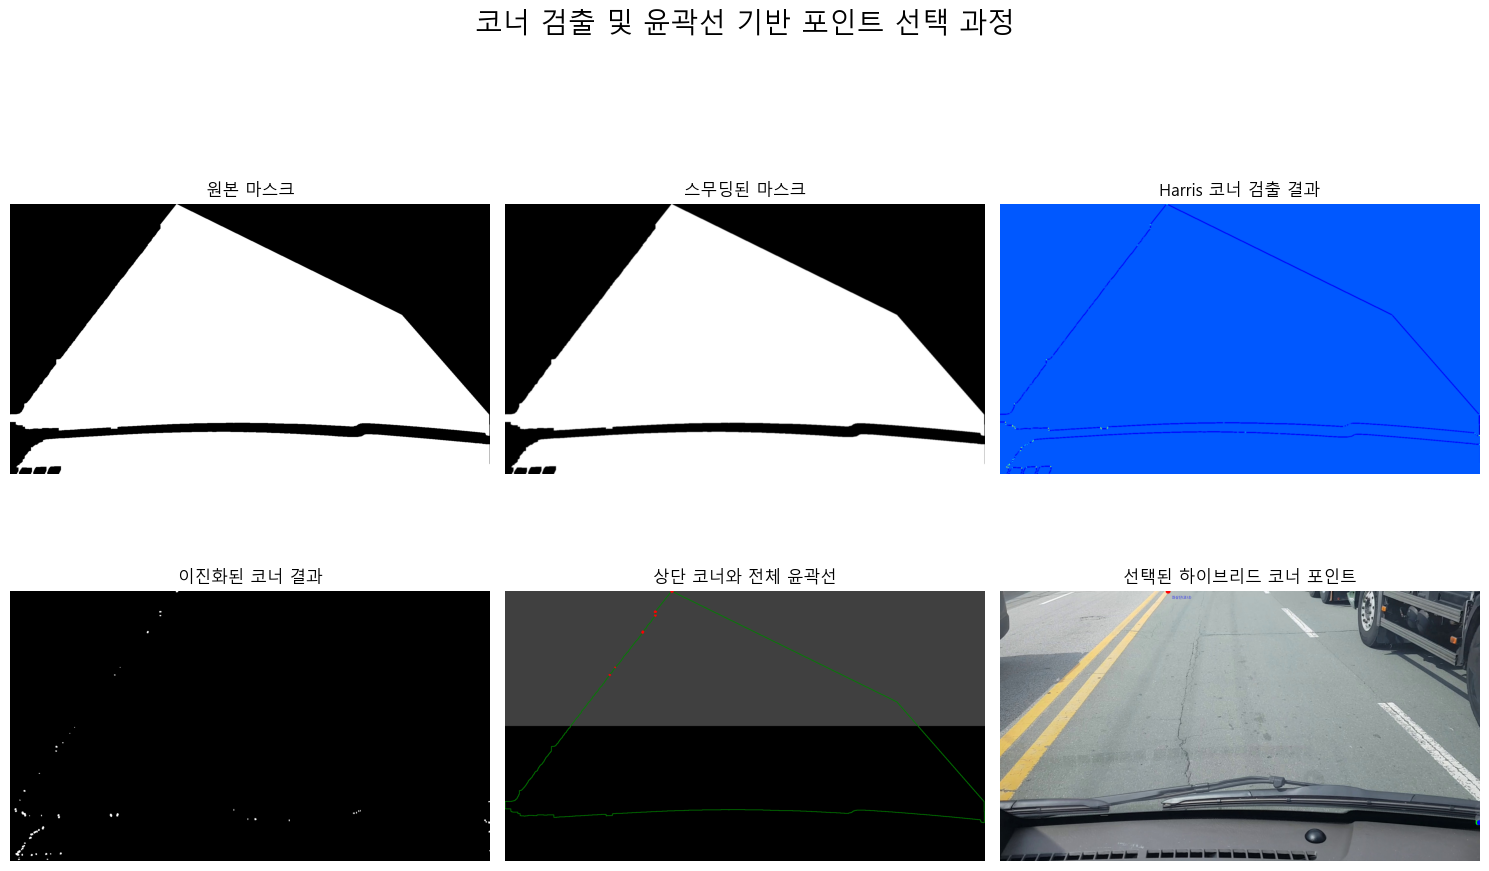


0: 576x1024 4 cracks, 759.9ms
Speed: 7.0ms preprocess, 759.9ms inference, 9.1ms postprocess per image at shape (1, 3, 576, 1024)


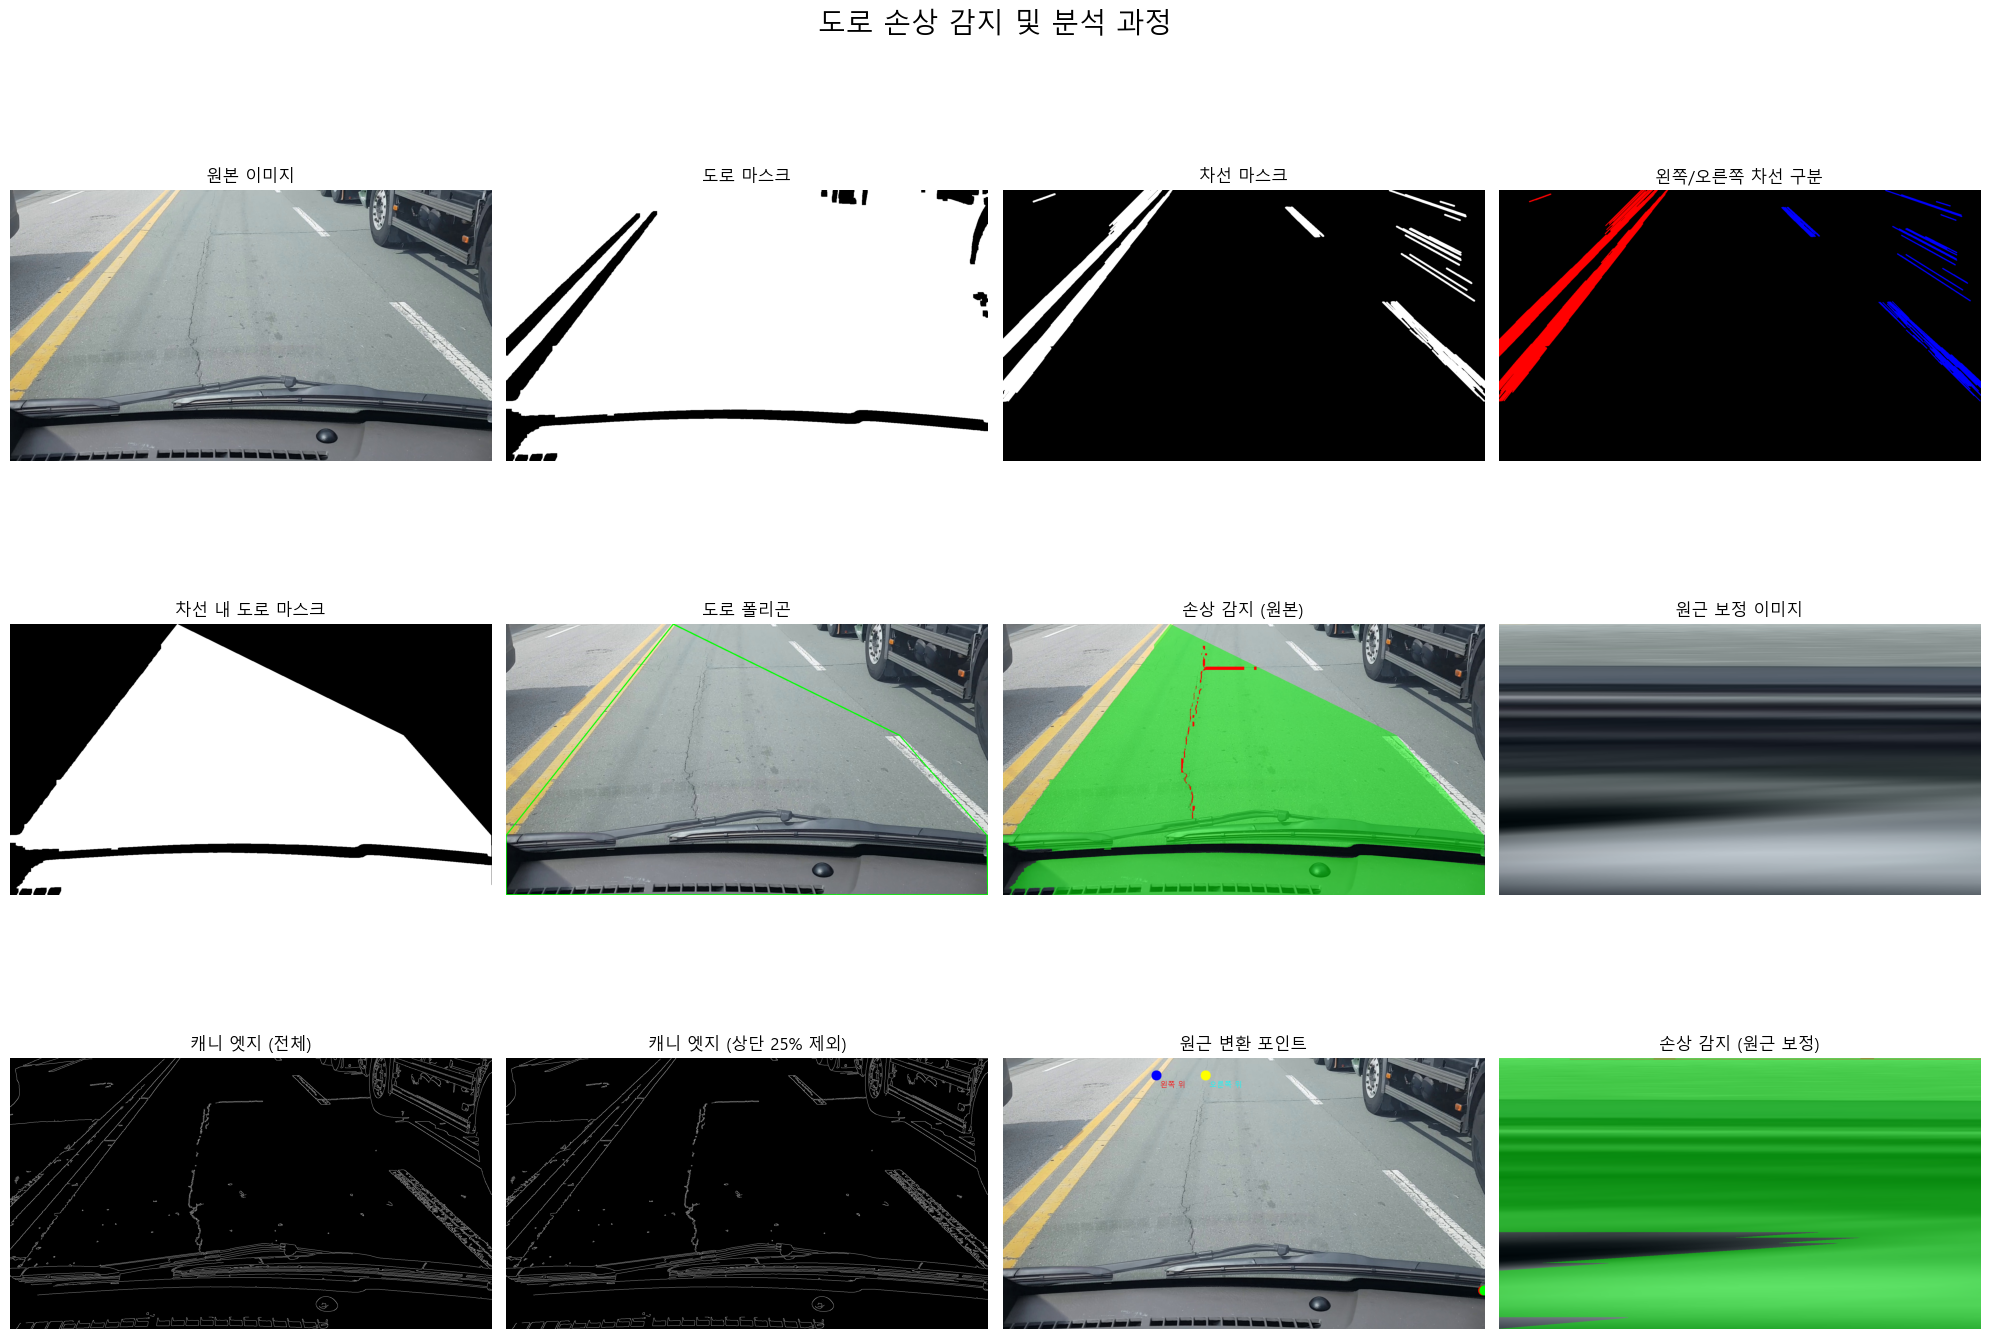


도로 영역 분석 결과:
도로 면적: 1260655 픽셀
균열 면적: 9859 픽셀 (0.78%)
포트홀 면적: 0 픽셀 (0.00%)
총 손상 면적: 9859 픽셀 (0.78%)

원근 보정된 도로 영역 분석 결과:
도로 면적: 2028345 픽셀
균열 면적: 2081 픽셀 (0.10%)
포트홀 면적: 0 픽셀 (0.00%)
총 손상 면적: 2081 픽셀 (0.10%)
분석 결과가 ../result/analysis_result_18.txt에 저장되었습니다.
핵심 이미지가 ../result/key_images_18.jpg에 저장되었습니다.


In [14]:
import cv2
import torch
import numpy as np
import os
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from ultralytics import YOLO

# matplotlib 한글 폰트 설정
import matplotlib.font_manager as fm
import platform

def setup_matplotlib_font():
    """운영체제별 matplotlib 한글 기본 폰트 설정 함수"""
    system = platform.system()
    if system == 'Windows':
        font_path = 'C:/Windows/Fonts/malgun.ttf'  # 윈도우의 경우 맑은 고딕
    elif system == 'Darwin':  # macOS
        font_path = '/System/Library/Fonts/AppleSDGothicNeo.ttc'
    else:  # Linux
        font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 우분투 기준 나눔고딕

    # 폰트 패스가 유효한지 확인
    try:
        font_prop = fm.FontProperties(fname=font_path)
        plt.rcParams['font.family'] = font_prop.get_name()
    except:
        print("기본 폰트를 사용합니다. 한글이 깨질 수 있습니다.")
        plt.rcParams['font.family'] = 'NanumGothic'  # 나눔고딕이 설치되어 있으면 사용

    # 그래프에서 마이너스 폰트 깨짐 방지
    plt.rcParams['axes.unicode_minus'] = False

def put_text_on_image(img, text, position, font_size=1, color=(255, 0, 0), thickness=2):
    """한글 텍스트를 이미지에 표시하는 함수"""
    # PIL 이미지로 변환
    pil_img = Image.fromarray(img)
    
    # 그리기 객체 생성
    draw = ImageDraw.Draw(pil_img)
    
    # 폰트 설정 (시스템에 맞게 조절 필요)
    system = platform.system()
    if system == 'Windows':
        font_path = 'C:/Windows/Fonts/malgun.ttf'  # 윈도우의 경우 맑은 고딕
    elif system == 'Darwin':  # macOS
        font_path = '/System/Library/Fonts/AppleSDGothicNeo.ttc'
    else:  # Linux
        font_path = '/usr/share/fonts/truetype/nanum/NanumGothic.ttf'  # 우분투 기준 나눔고딕
    
    try:
        font = ImageFont.truetype(font_path, int(font_size * 20))
    except:
        print("폰트를 로드할 수 없습니다. 기본 폰트를 사용합니다.")
        font = ImageFont.load_default()
    
    # 텍스트 그리기
    draw.text(position, text, font=font, fill=color[::-1])  # RGB -> BGR 변환
    
    # NumPy 배열로 변환하여 반환
    return np.array(pil_img)

def extract_road_mask(img):
    """도로 영역 추출 함수"""
    # 이미지 복사 및 크기 가져오기
    height, width = img.shape[:2]
    
    # 이미지 전처리: 가우시안 블러로 노이즈 제거
    blurred = cv2.GaussianBlur(img, (5, 5), 0)
    
    # HSV 변환
    hsv = cv2.cvtColor(blurred, cv2.COLOR_BGR2HSV)
    
    # 도로 색상 범위 (회색, 어두운 회색, 밝은 회색 포함)
    # 넓은 범위의 도로 색상 감지
    lower_gray_road = np.array([0, 0, 60])
    upper_gray_road = np.array([180, 50, 200])
    
    # 아스팔트 도로 (어두운 색상)
    lower_dark_road = np.array([0, 0, 30])
    upper_dark_road = np.array([180, 30, 120])
    
    # 콘크리트 도로 (밝은 색상)
    lower_light_road = np.array([0, 0, 130])
    upper_light_road = np.array([180, 40, 255])
    
    # 각 범위에 대한 마스크 생성
    gray_mask = cv2.inRange(hsv, lower_gray_road, upper_gray_road)
    dark_mask = cv2.inRange(hsv, lower_dark_road, upper_dark_road)
    light_mask = cv2.inRange(hsv, lower_light_road, upper_light_road)
    
    # 모든 마스크 결합
    road_mask = cv2.bitwise_or(gray_mask, dark_mask)
    road_mask = cv2.bitwise_or(road_mask, light_mask)
    
    # 작은 노이즈 제거
    kernel_open = np.ones((3, 3), np.uint8)
    road_mask = cv2.morphologyEx(road_mask, cv2.MORPH_OPEN, kernel_open)
    
    # 도로 영역 연결
    kernel_close = np.ones((7, 7), np.uint8)
    road_mask = cv2.morphologyEx(road_mask, cv2.MORPH_CLOSE, kernel_close)
    
    # 넓은 영역 닫기 연산으로 도로 틈새 메우기
    kernel_close_large = np.ones((15, 15), np.uint8)
    road_mask = cv2.morphologyEx(road_mask, cv2.MORPH_CLOSE, kernel_close_large)
    
    # 연결 요소 찾기
    contours, _ = cv2.findContours(road_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours:
        # 면적 기준으로 정렬된 상위 3개 연결 요소 선택
        sorted_contours = sorted(contours, key=cv2.contourArea, reverse=True)
        refined_mask = np.zeros_like(road_mask)
        
        # 이미지 전체 면적
        total_area = height * width
        
        # 상위 연결 요소 중 유의미한 크기인 것만 선택
        for contour in sorted_contours[:3]:
            area = cv2.contourArea(contour)
            if area > (total_area * 0.05):  # 전체 이미지의 5% 이상인 연결 요소만 고려
                cv2.drawContours(refined_mask, [contour], 0, 255, -1)
        
        # 최종 마스크가 비어있지 않은 경우에만 갱신
        if np.any(refined_mask):
            road_mask = refined_mask
            
        # 마스크의 하단 중앙에서 시작하여 홍수 채우기(Flood Fill)로 가장 가능성 높은 도로 영역 선택
        seed_point = (width // 2, int(height * 0.9))
        flood_mask = np.zeros((height+2, width+2), np.uint8)
        cv2.floodFill(road_mask.copy(), flood_mask, seed_point, 255, 0, 0, cv2.FLOODFILL_FIXED_RANGE)
        flood_mask = flood_mask[1:-1, 1:-1]  # 경계 제거
        
        # 가장 큰 연결 요소와 홍수 채우기 결과를 결합
        combined_mask = cv2.bitwise_or(road_mask, flood_mask)
        road_mask = combined_mask
    
    return road_mask

def detect_lane_lines(img):
    """차선 감지 및 마스크 생성 함수"""
    # 그레이스케일 변환
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # 가우시안 블러 및 엣지 감지
    blur = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blur, 50, 150)
    
    # ROI 설정
    height, width = edges.shape
    roi_mask = np.ones_like(edges)
    masked_edges = cv2.bitwise_and(edges, edges, mask=roi_mask)
    
    # 색상 기반 차선 추출 (흰색/노란색)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    
    # 흰색 및 노란색 범위 설정
    lower_white = np.array([0, 0, 200])
    upper_white = np.array([180, 30, 255])
    white_mask = cv2.inRange(hsv, lower_white, upper_white)
    
    lower_yellow = np.array([10, 60, 80])
    upper_yellow = np.array([40, 255, 255])
    yellow_mask = cv2.inRange(hsv, lower_yellow, upper_yellow)
    
    # 색상 마스크 통합 및 ROI 적용
    color_mask = cv2.bitwise_or(white_mask, yellow_mask)
    color_mask = cv2.bitwise_and(color_mask, color_mask, mask=roi_mask)
    
    # 최종 마스크 (엣지 + 색상)
    final_mask = cv2.bitwise_or(masked_edges, color_mask)
    
    # 호프 변환으로 직선 검출
    lines = cv2.HoughLinesP(
        final_mask, 
        rho=1, 
        theta=np.pi/180, 
        threshold=40,
        minLineLength=50,
        maxLineGap=2
    )
    
    # 차선 마스크 초기화
    lane_mask = np.zeros_like(gray)
    left_line_mask = np.zeros_like(gray)
    right_line_mask = np.zeros_like(gray)
    
    # 차선 필터링 및 분류
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            
            # 선의 길이가 너무 짧으면 무시
            if np.sqrt((x2 - x1)**2 + (y2 - y1)**2) < 30:
                continue
                
            # 기울기 계산
            if x2 - x1 == 0:  # 수직선 방지
                continue
            else:
                slope = (y2 - y1) / (x2 - x1)
            
            # 적절한 기울기 범위만 선택 (약 15도 ~ 65도 범위)
            if 0.3 < abs(slope) < 2:  
                cv2.line(lane_mask, (x1, y1), (x2, y2), 255, 3)
                
                # 왼쪽/오른쪽 차선 구분
                mid_x = width // 2
                line_mid_x = (x1 + x2) // 2
                
                if slope < 0 and line_mid_x < mid_x:  # 왼쪽 차선 (음수 기울기)
                    cv2.line(left_line_mask, (x1, y1), (x2, y2), 255, 3)
                elif slope > 0 and line_mid_x > mid_x:  # 오른쪽 차선 (양수 기울기)
                    cv2.line(right_line_mask, (x1, y1), (x2, y2), 255, 3)
    
    # 차선 마스크 확장
    kernel = np.ones((3, 3), np.uint8)
    lane_mask = cv2.dilate(lane_mask, kernel, iterations=1)
    
    return lane_mask, left_line_mask, right_line_mask, edges, masked_edges

def extract_road_between_lanes(img, road_mask, left_lane_mask, right_lane_mask):
    """차선 내부의 도로 영역 추출 함수"""
    height, width = road_mask.shape
    
    # 왼쪽과 오른쪽 차선 윤곽선 찾기
    left_contours, _ = cv2.findContours(left_lane_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    right_contours, _ = cv2.findContours(right_lane_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    # 차선 마스크가 충분하지 않으면 기본 도로 마스크 반환
    if not left_contours or not right_contours:
        return road_mask, None
    
    # 가장 큰 왼쪽/오른쪽 차선 윤곽선 선택
    left_contour = max(left_contours, key=cv2.contourArea) if left_contours else None
    right_contour = max(right_contours, key=cv2.contourArea) if right_contours else None
    
    if left_contour is None or right_contour is None:
        return road_mask, None
    
    # 왼쪽/오른쪽 차선의 외곽점 찾기
    left_points = left_contour.reshape(-1, 2)
    right_points = right_contour.reshape(-1, 2)
    
    # 각 차선에서 가장 아래/위 지점 찾기
    left_bottom = left_points[np.argmax(left_points[:, 1])]
    right_bottom = right_points[np.argmax(right_points[:, 1])]
    left_top = left_points[np.argmin(left_points[:, 1])]
    right_top = right_points[np.argmin(right_points[:, 1])]
    
    # 차선이 충분히 감지되지 않은 경우 대체 포인트 설정
    if np.linalg.norm(left_top - left_bottom) < 50:
        left_top[1] = max(0, height - height//3)
    
    if np.linalg.norm(right_top - right_bottom) < 50:
        right_top[1] = max(0, height - height//3)
        
    # 이미지 하단 좌표 추가
    bottom_left = [0, height-1]
    bottom_right = [width-1, height-1]
    
    # 도로 폴리곤 생성 (차선 내부 + 차선 아래 영역)
    road_polygon = np.array([
        bottom_left, left_bottom, left_top, right_top, right_bottom, bottom_right
    ], dtype=np.int32)
    
    # 도로 영역 마스크 생성
    lane_road_mask = np.zeros_like(road_mask)
    cv2.fillPoly(lane_road_mask, [road_polygon], 255)
    
    # 원래 도로 마스크와 교차
    final_road_mask = cv2.bitwise_and(road_mask, lane_road_mask)
    
    return final_road_mask, road_polygon

def get_default_perspective_points(road_polygon, height, width):
    """road_polygon이 있을 경우 사용하고, 없으면 기본값 설정"""
    if road_polygon is not None and len(road_polygon) >= 6:
        # road_polygon에서 필요한 포인트 추출
        left_bottom = road_polygon[1]  # 왼쪽 차선 하단
        right_bottom = road_polygon[4] # 오른쪽 차선 하단
        left_top = road_polygon[2]     # 왼쪽 차선 상단
        right_top = road_polygon[3]    # 오른쪽 차선 상단
        
        # 사용할 코너 포인트
        return np.float32([left_bottom, right_bottom, left_top, right_top])
    else:
        # 기본값 설정
        bottom_left = np.array([0, height-1])
        bottom_right = np.array([width-1, height-1])
        top_left = np.array([width//4, height//3])
        top_right = np.array([width*3//4, height//3])
        
        return np.float32([bottom_left, bottom_right, top_left, top_right])

def perspective_transform(img, mask, road_polygon=None):
    """
    원근 변환 함수 - 상단과 하단 포인트 모두 코너 특징점으로 찾기
    """
    height, width = mask.shape
    
    # 코너 검출에 적합한 마스크 준비
    mask_smooth = cv2.GaussianBlur(mask, (5, 5), 0)
    
    # Harris 코너 검출
    corners = cv2.cornerHarris(mask_smooth, blockSize=5, ksize=3, k=0.04)
    
    # 코너 검출 결과를 이진화하고 팽창 (더 뚜렷하게)
    corners_dilated = cv2.dilate(corners, None)
    _, corners_binary = cv2.threshold(corners_dilated, 0.01 * corners_dilated.max(), 255, 0)
    corners_binary = np.uint8(corners_binary)

    # 코너 포인트 좌표 추출
    corner_coords = np.where(corners_binary > 0)
    corner_y = corner_coords[0]
    corner_x = corner_coords[1]
    
    # 모든 코너 좌표를 리스트로 변환
    all_corners = []
    for i in range(len(corner_y)):
        all_corners.append([corner_x[i], corner_y[i]])
    
    # 코너가 충분히 많지 않으면 대체 방식 사용
    if len(all_corners) < 10:
        return fallback_perspective_transform(img, mask, road_polygon)
    
    # 이미지를 4분할하여 각 영역에서 코너점 찾기
    h_mid = height // 2
    w_mid = width // 2
    
    # 각 영역의 코너 포인트
    top_left_corners = [p for p in all_corners if p[0] < w_mid and p[1] < h_mid]
    top_right_corners = [p for p in all_corners if p[0] >= w_mid and p[1] < h_mid]
    bottom_left_corners = [p for p in all_corners if p[0] < w_mid and p[1] >= h_mid]
    bottom_right_corners = [p for p in all_corners if p[0] >= w_mid and p[1] >= h_mid]
    
    # 각 영역에 코너가 없는 경우 대체 방법 사용
    if not (top_left_corners and top_right_corners and bottom_left_corners and bottom_right_corners):
        return fallback_perspective_transform(img, mask, road_polygon)
    
    # 좌상단: 원점에 가까운 포인트들 중에서 선택
    top_left_candidates = sorted(top_left_corners, key=lambda p: p[0]**2 + p[1]**2)
    top_left = top_left_candidates[0] if top_left_candidates else None
    
    # 우상단: 오른쪽 상단 모서리에 가까운 포인트들 중에서 선택
    top_right_candidates = sorted(top_right_corners, key=lambda p: (p[0]-width)**2 + p[1]**2)
    top_right = top_right_candidates[0] if top_right_candidates else None
    
    # 좌하단: 왼쪽 하단 모서리에 가까운 포인트들 중에서 선택
    bottom_left_candidates = sorted(bottom_left_corners, key=lambda p: p[0]**2 + (p[1]-height)**2)
    bottom_left = bottom_left_candidates[0] if bottom_left_candidates else None
    
    # 우하단: 오른쪽 하단 모서리에 가까운 포인트들 중에서 선택
    bottom_right_candidates = sorted(bottom_right_corners, key=lambda p: (p[0]-width)**2 + (p[1]-height)**2)
    bottom_right = bottom_right_candidates[0] if bottom_right_candidates else None
    
    # 모든 코너가 찾아졌는지 확인
    if not all([top_left, top_right, bottom_left, bottom_right]):
        return fallback_perspective_transform(img, mask, road_polygon)
    
    # 도로 형태가 일반적인 사다리꼴인지 확인
    # 상단 포인트의 y좌표가 하단 포인트보다 작아야 함
    if not (top_left[1] < bottom_left[1] and top_right[1] < bottom_right[1]):
        return fallback_perspective_transform(img, mask, road_polygon)
    
    # 왼쪽 포인트의 x좌표가 오른쪽 포인트보다 작아야 함
    if not (top_left[0] < top_right[0] and bottom_left[0] < bottom_right[0]):
        return fallback_perspective_transform(img, mask, road_polygon)
    
    # 추가적인 유효성 검사: 코너 간의 거리가 충분한지 확인
    min_distance = 20  # 최소 거리 (픽셀 단위)
    
    def distance(p1, p2):
        return np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)
    
    distances = [
        distance(top_left, top_right),
        distance(top_left, bottom_left),
        distance(top_right, bottom_right),
        distance(bottom_left, bottom_right)
    ]
    
    if min(distances) < min_distance:
        return fallback_perspective_transform(img, mask, road_polygon)
    
    # 도로 마스크 영역 내에 모든 점이 있는지 확인
    # 도로 윤곽선 찾기
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return fallback_perspective_transform(img, mask, road_polygon)
    
    # 도로 영역 내부에 코너가 있는지 확인
    all_points = [top_left, top_right, bottom_left, bottom_right]
    mask_inside = np.zeros_like(mask)
    cv2.drawContours(mask_inside, contours, -1, 255, -1)
    
    # 원근 변환에 사용할 소스 포인트
    src_points = np.float32([
        bottom_left,    # 좌하단
        bottom_right,   # 우하단
        top_left,       # 좌상단
        top_right       # 우상단
    ])
    
    # 타겟 포인트 설정 (변환 후 이미지에서의 위치)
    dst_points = np.float32([
        [0, height-1],               # 왼쪽 하단
        [width-1, height-1],         # 오른쪽 하단
        [0, 0],                      # 왼쪽 상단
        [width-1, 0]                 # 오른쪽 상단
    ])
    
    # 원근 변환 행렬 계산 및 적용
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    warped_img = cv2.warpPerspective(img, M, (width, height))
    warped_mask = cv2.warpPerspective(mask, M, (width, height))
    
    return warped_img, warped_mask, M, src_points

def fallback_perspective_transform(img, mask, road_polygon=None):
    """
    코너 검출이 실패했을 때 사용하는 대체 원근 변환 함수
    기존의 방식을 사용
    """
    height, width = mask.shape
    
    # 도로 마스크에서 윤곽선 찾기
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if contours and len(contours) > 0:
        # 가장 큰 윤곽선 선택
        main_contour = max(contours, key=cv2.contourArea)
        all_points = main_contour.reshape(-1, 2)
        
        if len(all_points) > 0:
            # 왼쪽 하단: x값 최소, y값 최대
            left_bottom_idx = np.lexsort((all_points[:, 0], -all_points[:, 1]))[0]
            left_bottom = all_points[left_bottom_idx]
            
            # 오른쪽 하단: x값 최대, y값 최대
            right_bottom_idx = np.lexsort((-all_points[:, 0], -all_points[:, 1]))[0]
            right_bottom = all_points[right_bottom_idx]
            
            # 상단 부분의 포인트 추출 (y값이 하위 10% 이내인 점들)
            y_threshold = np.percentile(all_points[:, 1], 10)
            top_points = all_points[all_points[:, 1] <= y_threshold]
            
            if len(top_points) > 0:
                # 왼쪽 상단: 상단 부분에서 x값이 가장 작은 점
                left_top_idx = np.argmin(top_points[:, 0])
                left_top = top_points[left_top_idx]
                
                # 오른쪽 상단: 상단 부분에서 x값이 가장 큰 점
                right_top_idx = np.argmax(top_points[:, 0])
                right_top = top_points[right_top_idx]
            else:
                # 상단 부분 포인트가 부족한 경우, y값을 우선 정렬하여 가장 작은 y값을 가진 포인트 중에서 선택
                sorted_by_y = all_points[np.argsort(all_points[:, 1])]
                top_n_points = sorted_by_y[:max(5, len(sorted_by_y) // 10)]  # 상위 10% 또는 최소 5개
                
                # 이 포인트들 중에서 왼쪽/오른쪽 구분
                left_top_idx = np.argmin(top_n_points[:, 0])
                left_top = top_n_points[left_top_idx]
                
                right_top_idx = np.argmax(top_n_points[:, 0])
                right_top = top_n_points[right_top_idx]
            
            src_points = np.float32([left_bottom, right_bottom, left_top, right_top])
        else:
            # 포인트가 없는 경우 기본값 사용
            src_points = get_default_perspective_points(road_polygon, height, width)
    else:
        # 윤곽선이 없는 경우 기본값 사용
        src_points = get_default_perspective_points(road_polygon, height, width)
    
    # 타겟 포인트 설정 (변환 후 이미지에서의 위치)
    dst_points = np.float32([
        [0, height-1],               # 왼쪽 하단
        [width-1, height-1],         # 오른쪽 하단
        [0, 0],                      # 왼쪽 상단
        [width-1, 0]                 # 오른쪽 상단
    ])
    
    # 원근 변환 행렬 계산 및 적용
    M = cv2.getPerspectiveTransform(src_points, dst_points)
    warped_img = cv2.warpPerspective(img, M, (width, height))
    warped_mask = cv2.warpPerspective(mask, M, (width, height))
    
    return warped_img, warped_mask, M, src_points

def apply_yolo_on_masked_area(model, img, mask):
    """마스크된 영역에서 YOLO 추론 수행"""
    # 마스크를 3채널로 확장
    mask_3ch = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    
    # 마스크 적용된 이미지 생성
    masked_img = cv2.bitwise_and(img, mask_3ch)
    
    # YOLO 추론
    results = model(masked_img)
    res = results[0]
    
    # 클래스별 마스크 생성
    mask_crack = np.zeros(img.shape[:2], dtype=np.uint8)
    mask_pothole = np.zeros(img.shape[:2], dtype=np.uint8)
    
    for i, box in enumerate(res.boxes):
        cls = int(box.cls[0])
        if i < len(res.masks):  # 안전하게 인덱스 확인
            single_mask = res.masks.data[i].cpu().numpy()
            binary_mask = (single_mask > 0.5).astype(np.uint8) * 255
            binary_mask_resized = cv2.resize(binary_mask, (img.shape[1], img.shape[0]))
            
            if cls == 0:  # crack
                mask_crack = cv2.bitwise_or(mask_crack, binary_mask_resized)
            elif cls == 1:  # pothole
                mask_pothole = cv2.bitwise_or(mask_pothole, binary_mask_resized)
    
    return mask_crack, mask_pothole

def save_analysis_results(road_area, crack_area, pothole_area, warped_road_area, warped_crack_area, warped_pothole_area, img_num):
    """분석 결과를 텍스트 파일로 저장하는 함수"""
    # 결과 저장 경로
    result_dir = '../result/'
    
    # 디렉토리가 없으면 생성
    os.makedirs(result_dir, exist_ok=True)
    
    # 파일 경로 설정
    file_path = os.path.join(result_dir, f'analysis_result_{img_num}.txt')
    
    # 결과 작성
    with open(file_path, 'w', encoding='utf-8') as f:
        f.write(f"도로 영역 분석 결과:\n")
        f.write(f"도로 면적: {road_area} 픽셀\n")
        f.write(f"균열 면적: {crack_area} 픽셀 ({crack_area/road_area*100:.2f}%)\n")
        f.write(f"포트홀 면적: {pothole_area} 픽셀 ({pothole_area/road_area*100:.2f}%)\n")
        f.write(f"총 손상 면적: {crack_area + pothole_area} 픽셀 ({(crack_area + pothole_area)/road_area*100:.2f}%)\n\n")
        
        f.write(f"원근 보정된 도로 영역 분석 결과:\n")
        f.write(f"도로 면적: {warped_road_area} 픽셀\n")
        f.write(f"균열 면적: {warped_crack_area} 픽셀 ({warped_crack_area/warped_road_area*100:.2f}%)\n")
        f.write(f"포트홀 면적: {warped_pothole_area} 픽셀 ({warped_pothole_area/warped_road_area*100:.2f}%)\n")
        f.write(f"총 손상 면적: {warped_crack_area + warped_pothole_area} 픽셀 ({(warped_crack_area + warped_pothole_area)/warped_road_area*100:.2f}%)\n")
    
    print(f"분석 결과가 {file_path}에 저장되었습니다.")

def save_key_images(original_img, overlay_original, img_with_points, overlay_warped, img_num):
    """핵심 이미지 4개를 하나의 이미지 파일로 저장하는 함수"""
    # 결과 저장 경로
    result_dir = '../result/'
    
    # 디렉토리가 없으면 생성
    os.makedirs(result_dir, exist_ok=True)
    
    # 파일 경로 설정
    file_path = os.path.join(result_dir, f'key_images_{img_num}.jpg')
    
    # 2x2 그리드로 이미지 배치
    plt.figure(figsize=(15, 12))
    
    plt.subplot(2, 2, 1)
    plt.imshow(original_img)
    plt.title('원본 이미지')
    plt.axis('off')
    
    plt.subplot(2, 2, 2)
    plt.imshow(overlay_original)
    plt.title('손상 감지 (원본)')
    plt.axis('off')
    
    plt.subplot(2, 2, 3)
    plt.imshow(img_with_points)
    plt.title('원근 변환 포인트')
    plt.axis('off')
    
    plt.subplot(2, 2, 4)
    plt.imshow(overlay_warped)
    plt.title('손상 감지 (원근 보정)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle(f"도로 손상 분석 결과 (이미지 {img_num})", fontsize=16)
    plt.subplots_adjust(top=0.9)
    
    # 이미지 저장
    plt.savefig(file_path, dpi=300, bbox_inches='tight')
    plt.close()
    
    print(f"핵심 이미지가 {file_path}에 저장되었습니다.")

def visualize_corner_detection(img, mask):
    """코너 검출 과정과 결과를 시각화하는 함수 - 하이브리드 방식 시각화"""
    height, width = mask.shape
    
    # 코너 검출에 사용된 마스크 준비
    mask_smooth = cv2.GaussianBlur(mask, (5, 5), 0)
    
    # Harris 코너 검출
    corners = cv2.cornerHarris(mask_smooth, blockSize=5, ksize=3, k=0.04)
    
    # 결과 이진화 및 팽창
    corners_dilated = cv2.dilate(corners, None)
    _, corners_binary = cv2.threshold(corners_dilated, 0.01 * corners_dilated.max(), 255, 0)
    corners_binary = np.uint8(corners_binary)

    # 코너 좌표 추출
    corner_coords = np.where(corners_binary > 0)
    all_corners = []
    for i in range(len(corner_coords[0])):
        all_corners.append([corner_coords[1][i], corner_coords[0][i]])  # x, y 순서로 저장
    
    # 이미지 상단/하단 구분
    h_mid = height // 2
    w_mid = width // 2
    
    # 상단 영역의 코너 포인트 분류
    top_left_corners = [p for p in all_corners if p[0] < w_mid and p[1] < h_mid]
    top_right_corners = [p for p in all_corners if p[0] >= w_mid and p[1] < h_mid]
    
    # 최적의 상단 코너 포인트 계산
    selected_corners = []
    if top_left_corners:
        top_left = min(top_left_corners, key=lambda p: (p[0]-w_mid)**2 + p[1]**2)
        selected_corners.append(top_left)
    
    if top_right_corners:
        top_right = min(top_right_corners, key=lambda p: (p[0]-w_mid)**2 + p[1]**2)
        selected_corners.append(top_right)
    
    # 하단 포인트 계산 (기존 방식)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours and len(contours) > 0:
        main_contour = max(contours, key=cv2.contourArea)
        all_points = main_contour.reshape(-1, 2)
        
        if len(all_points) > 0:
            # 왼쪽 하단: x값 최소, y값 최대
            left_bottom_idx = np.lexsort((all_points[:, 0], -all_points[:, 1]))[0]
            bottom_left = all_points[left_bottom_idx]
            selected_corners.append(bottom_left)
            
            # 오른쪽 하단: x값 최대, y값 최대
            right_bottom_idx = np.lexsort((-all_points[:, 0], -all_points[:, 1]))[0]
            bottom_right = all_points[right_bottom_idx]
            selected_corners.append(bottom_right)
    
    # 시각화
    plt.figure(figsize=(15, 10))
    
    # 원본 마스크
    plt.subplot(2, 3, 1)
    plt.imshow(mask, cmap='gray')
    plt.title('원본 마스크')
    plt.axis('off')
    
    # 스무딩된 마스크
    plt.subplot(2, 3, 2)
    plt.imshow(mask_smooth, cmap='gray')
    plt.title('스무딩된 마스크')
    plt.axis('off')
    
    # Harris 코너 검출 결과
    plt.subplot(2, 3, 3)
    plt.imshow(corners, cmap='jet')
    plt.title('Harris 코너 검출 결과')
    plt.axis('off')
    
    # 이진화된 코너 결과
    plt.subplot(2, 3, 4)
    plt.imshow(corners_binary, cmap='gray')
    plt.title('이진화된 코너 결과')
    plt.axis('off')
    
    # 상단 코너와 윤곽선 구분
    plt.subplot(2, 3, 5)
    visualization = np.zeros((height, width, 3), dtype=np.uint8)
    
    # 상단 영역 표시 (밝은 회색)
    visualization[:h_mid, :] = [64, 64, 64]
    
    # 윤곽선 표시
    if contours and len(contours) > 0:
        cv2.drawContours(visualization, [main_contour], 0, [0, 128, 0], 2)
    
    # 상단 코너 표시
    for p in top_left_corners:
        cv2.circle(visualization, tuple(p), 2, [255, 0, 0], -1)  # 빨간색
    for p in top_right_corners:
        cv2.circle(visualization, tuple(p), 2, [0, 255, 0], -1)  # 초록색
    
    plt.imshow(visualization)
    plt.title('상단 코너와 전체 윤곽선')
    plt.axis('off')
    
    # 선택된 코너 포인트
    plt.subplot(2, 3, 6)
    img_with_corners = img.copy()
    point_names = ['좌상단(코너)', '우상단(코너)', '좌하단(윤곽선)', '우하단(윤곽선)']
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]
    
    for i, p in enumerate(selected_corners):
        if i < len(point_names):
            cv2.circle(img_with_corners, tuple(p), 10, colors[i], -1)
            # PIL로 한글 텍스트 추가
            img_with_corners = put_text_on_image(
                img_with_corners, 
                point_names[i], 
                (p[0] + 15, p[1] + 15), 
                font_size=0.7, 
                color=colors[i]
            )
    
    plt.imshow(img_with_corners)
    plt.title('선택된 하이브리드 코너 포인트')
    plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle("코너 검출 및 윤곽선 기반 포인트 선택 과정", fontsize=20)
    plt.subplots_adjust(top=0.9)
    plt.show()

def visualize_results(original_img, road_mask, lane_mask, left_lane_mask, right_lane_mask,
                     road_lane_mask, road_polygon, mask_crack, mask_pothole, 
                     warped_img, warped_mask, warped_crack, warped_pothole, corner_points,
                     edges, masked_edges, img_num):  # img_num 매개변수 추가
    """결과 시각화 함수"""
    plt.figure(figsize=(20, 15))
    
    # 첫 번째 행: 기본 이미지와 마스크
    plt.subplot(3, 4, 1)
    plt.imshow(original_img)
    plt.title('원본 이미지')
    plt.axis('off')
    
    plt.subplot(3, 4, 2)
    plt.imshow(road_mask, cmap='gray')
    plt.title('도로 마스크')
    plt.axis('off')
    
    plt.subplot(3, 4, 3)
    plt.imshow(lane_mask, cmap='gray')
    plt.title('차선 마스크')
    plt.axis('off')
    
    # 왼쪽/오른쪽 차선 구분
    plt.subplot(3, 4, 4)
    lane_combined = np.zeros((original_img.shape[0], original_img.shape[1], 3), dtype=np.uint8)
    lane_combined[left_lane_mask == 255] = [255, 0, 0]  # 왼쪽 차선: 빨간색
    lane_combined[right_lane_mask == 255] = [0, 0, 255]  # 오른쪽 차선: 파란색
    plt.imshow(lane_combined)
    plt.title('왼쪽/오른쪽 차선 구분')
    plt.axis('off')
    
    # 두 번째 행: 도로 분석
    plt.subplot(3, 4, 5)
    plt.imshow(road_lane_mask, cmap='gray')
    plt.title('차선 내 도로 마스크')
    plt.axis('off')
    
    plt.subplot(3, 4, 6)
    polygon_viz = original_img.copy()
    cv2.polylines(polygon_viz, [road_polygon], True, (0, 255, 0), 3)
    plt.imshow(polygon_viz)
    plt.title('도로 폴리곤')
    plt.axis('off')
    
    # 손상 감지 시각화 (원본)
    plt.subplot(3, 4, 7)
    overlay_original = original_img.copy()
    alpha = 0.5
    road_overlay = overlay_original.copy()
    road_overlay[road_lane_mask == 255] = [0, 255, 0]  # 도로: 초록색
    overlay_original = cv2.addWeighted(road_overlay, alpha, overlay_original, 1-alpha, 0)
    overlay_original[mask_crack == 255] = [255, 0, 0]  # 균열: 빨간색
    overlay_original[mask_pothole == 255] = [0, 0, 255]  # 포트홀: 파란색
    plt.imshow(overlay_original)
    plt.title('손상 감지 (원본)')
    plt.axis('off')
    
    plt.subplot(3, 4, 8)
    plt.imshow(warped_img)
    plt.title('원근 보정 이미지')
    plt.axis('off')
    
    # 세 번째 행: 추가 분석
    plt.subplot(3, 4, 9)
    plt.imshow(edges, cmap='gray')
    plt.title('캐니 엣지 (전체)')
    plt.axis('off')
    
    plt.subplot(3, 4, 10)
    plt.imshow(masked_edges, cmap='gray')
    plt.title('캐니 엣지 (상단 25% 제외)')
    plt.axis('off')
    
    # 원근 변환 포인트 시각화
    plt.subplot(3, 4, 11)
    img_with_points = original_img.copy()
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (255, 255, 0)]
    point_names = ['왼쪽 아래', '오른쪽 아래', '왼쪽 위', '오른쪽 위']
    
    for i, point in enumerate(corner_points):
        cv2.circle(img_with_points, (int(point[0]), int(point[1])), 20, colors[i], -1)
        # PIL로 한글 텍스트 추가
        img_with_points = put_text_on_image(
            img_with_points, 
            point_names[i], 
            (int(point[0]) + 15, int(point[1]) + 15), 
            font_size=1.5, 
            color=colors[i]
        )
    plt.imshow(img_with_points)
    plt.title('원근 변환 포인트')
    plt.axis('off')
    
    # 원근 보정된 손상 감지
    plt.subplot(3, 4, 12)
    overlay_warped = warped_img.copy()
    road_overlay_warped = overlay_warped.copy()
    road_overlay_warped[warped_mask == 255] = [0, 255, 0]
    overlay_warped = cv2.addWeighted(road_overlay_warped, alpha, overlay_warped, 1-alpha, 0)
    overlay_warped[warped_crack == 255] = [255, 0, 0]
    overlay_warped[warped_pothole == 255] = [0, 0, 255]
    plt.imshow(overlay_warped)
    plt.title('손상 감지 (원근 보정)')
    plt.axis('off')
    
    plt.tight_layout()
    plt.suptitle("도로 손상 감지 및 분석 과정", fontsize=20)
    plt.subplots_adjust(top=0.95)
    plt.show()
    
    # 손상 면적 계산 및 출력
    road_area = np.count_nonzero(road_lane_mask)
    crack_area = np.count_nonzero(cv2.bitwise_and(mask_crack, road_lane_mask))
    pothole_area = np.count_nonzero(cv2.bitwise_and(mask_pothole, road_lane_mask))
    
    print(f"\n도로 영역 분석 결과:")
    print(f"도로 면적: {road_area} 픽셀")
    print(f"균열 면적: {crack_area} 픽셀 ({crack_area/road_area*100:.2f}%)")
    print(f"포트홀 면적: {pothole_area} 픽셀 ({pothole_area/road_area*100:.2f}%)")
    print(f"총 손상 면적: {crack_area + pothole_area} 픽셀 ({(crack_area + pothole_area)/road_area*100:.2f}%)")

    # 원근 보정된 이미지에서의 손상 면적 계산 및 출력
    warped_road_area = np.count_nonzero(warped_mask)
    warped_crack_area = np.count_nonzero(cv2.bitwise_and(warped_crack, warped_mask))
    warped_pothole_area = np.count_nonzero(cv2.bitwise_and(warped_pothole, warped_mask))
    
    print(f"\n원근 보정된 도로 영역 분석 결과:")
    print(f"도로 면적: {warped_road_area} 픽셀")
    print(f"균열 면적: {warped_crack_area} 픽셀 ({warped_crack_area/warped_road_area*100:.2f}%)")
    print(f"포트홀 면적: {warped_pothole_area} 픽셀 ({warped_pothole_area/warped_road_area*100:.2f}%)")
    print(f"총 손상 면적: {warped_crack_area + warped_pothole_area} 픽셀 ({(warped_crack_area + warped_pothole_area)/warped_road_area*100:.2f}%)")

    # 분석 결과 텍스트 파일로 저장
    save_analysis_results(road_area, crack_area, pothole_area, warped_road_area, warped_crack_area, warped_pothole_area, img_num)
    
    # 핵심 이미지 저장
    save_key_images(original_img, overlay_original, img_with_points, overlay_warped, img_num)

def main():
    # 폰트 설정
    setup_matplotlib_font()
    
    # 모델 로드
    model_path = '../model/yolo11l-seg.pt'
    model = YOLO(model_path)
    print(f"YOLOv11-seg 모델 '{model_path}'을(를) 로드했습니다.")
    
    # 이미지 로드
    img_num = input("테스트할 이미지 번호를 입력하세요: ")
    img_path = f'../image/test_image_{img_num}.jpg'
    print(f"이미지 '{img_path}'을(를) 로드했습니다.")
    img_bgr = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    img_height, img_width = img_rgb.shape[:2]
    
    # 도로 마스크 생성
    road_mask = extract_road_mask(img_bgr)
    
    # 차선 마스크 생성
    lane_mask, left_lane_mask, right_lane_mask, edges, masked_edges = detect_lane_lines(img_bgr)
    
    # 차선 내부의 도로와 아래 부분까지 마스크
    road_lane_mask, road_polygon = extract_road_between_lanes(img_bgr, road_mask, left_lane_mask, right_lane_mask)
    
    # 코너 검출 과정 시각화 (선택 사항)
    visualize_corner_detection(img_rgb, road_lane_mask)
    
    # 마스크된 영역에서 YOLO 추론
    mask_crack, mask_pothole = apply_yolo_on_masked_area(model, img_rgb, road_lane_mask)
    
    # 원근 변환 적용 - road_lane_mask를 사용
    warped_img, warped_mask, perspective_matrix, corner_points = perspective_transform(
        img_rgb, road_lane_mask, road_polygon)
    
    # 손상 마스크에도 원근 변환 적용
    warped_crack = cv2.warpPerspective(mask_crack, perspective_matrix, (img_width, img_height))
    warped_pothole = cv2.warpPerspective(mask_pothole, perspective_matrix, (img_width, img_height))
    
    # 결과 시각화 - img_num 인자 추가
    visualize_results(
        img_rgb, road_mask, lane_mask, left_lane_mask, right_lane_mask,
        road_lane_mask, road_polygon, mask_crack, mask_pothole, 
        warped_img, warped_mask, warped_crack, warped_pothole, corner_points,
        edges, masked_edges, img_num
    )

if __name__ == "__main__":
    main()

# 마지막 지점

    1. 이미지 불러오기
    2. 가우시안 블러 : 노이즈 제거
    3. HSV 변환 : HSV(색조, 채도, 명도)를 활용한 색상 분리의 용이성
    4. 도로 색상 범위 설정
    5. 도로 마스크 생성
    6. 모폴로지(열림) 적용 : 주변보다 밝은 노이즈 제거, 독립된 개체 분리, 돌출된 모양 제거
    7. 모폴로지(닫힘) 적용 : 주변보다 어두운 노이즈 제거, 끊어져 보이는 개체 연결, 틈새 메우기